# Package Setup

## pip installs

In [85]:
!pip install datasets
!pip install wordcloud
!pip install gensim nltk scikit-learn tqdm
!pip install glove-python-binary
!pip install OpenAI
!pip install tiktoken
!pip install xgboost
!pip install sentence-transformers



ERROR: Could not find a version that satisfies the requirement glove-python-binary (from versions: none)
ERROR: No matching distribution found for glove-python-binary


   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/113.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/113.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/113.8 MB 1.0 MB/s eta 0:01:48
   ---------------------------------------- 0.8/113.8 MB 1.1 MB/s eta 0:01:42
   ---------------------------------------- 1.0/113.8 MB 1.2 MB/s eta 0:01:32
    --------------------------------------- 1.6/113.8 MB 1.4 MB/s eta 0:01:23
    --------------------------------------- 1.8/113.8 MB 1.4 MB/s eta 0:01:19
    --------------------------------------- 2.4/113.8 MB 1.5 MB/s eta 0:01:13
   - -------------------------------------- 2.9/113.8 MB 1.7 MB/s eta 0:01:07
   - -------------------------------------- 3.4/113.8 MB 1.8 MB/s eta 0:01:03
   - -------------------------------------- 4.2/113.8 MB 1.9 MB/s eta 0:00:57
   - -------------------------------------- 4.7/113.8 MB 2.0 MB/s eta 0:00:54
   - --

## imports


In [ ]:
# --- Core Python ---
import os
import re
import math
import time
import random
import string
import asyncio
from collections import Counter, defaultdict

# --- Data & Math ---
import numpy as np
import pandas as pd
from scipy.stats import entropy

# --- Visualization ---
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# --- NLP (NLTK + Tokenization) ---
import nltk
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# --- NLP (Other libraries) ---
from datasets import load_dataset
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer, util

# --- Feature Extraction ---
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# --- Machine Learning ---
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    train_test_split, GroupKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator
from xgboost import XGBClassifier

# --- Async / API / Requests ---
import requests
import difflib
import nest_asyncio
import aiohttp
from openai import OpenAI, AsyncOpenAI
import tiktoken


## downlodes

In [51]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Us

True

## MISC

In [ ]:
nest_asyncio.apply()


# DATA creation

## Raw Data

In [36]:
new_dataset = load_dataset("dmitva/human_ai_generated_text")
new_data = new_dataset["train"].to_pandas()
new_data.head()

KeyboardInterrupt: 

In [ ]:
new_data= new_data[['human_text','instructions']]
new_data

,human_text,instructions
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...
2,parents and school should agree on the desicio...,Task: \n\n1. Talk to your parents before takin...
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...
4,Many people around the world have different ch...,Task: Research and discuss how character trait...
...,...,...
999995,You can meet up with your family at the park. ...,Task: Research reasons why people might find c...
999996,Even small chores prepare us for something big...,Task: \n\n1. Research the history of the US an...
999997,"Sometimes people say, ""technology is bad becau...",Task: Write an essay exploring how technology ...
999998,if we had enough time it would had really help...,Task: \n1. Research the effects of adding an a...


## OpenAI API

In [ ]:
client = AsyncOpenAI(api_key="API_KEY")

# Load full dataset every time
df = new_data.copy()
df["ai_response"] = df.get("ai_response", None)

output_path = "ai_responses_progress.csv"
backup_path = "ai_responses_backup.csv"

# ----------------------------------------
# Restore progress WITHOUT replacing df
# ----------------------------------------
if os.path.exists(output_path):
    print("Merging saved progress...")
    saved = pd.read_csv(output_path)

    # Fill ai_response values for matching indices
    df.loc[saved.index, "ai_response"] = saved["ai_response"]


# ---------------------------
# ASYNC RESPONSE GENERATOR
# ---------------------------
async def generate_ai_response(instruction):
    while True:
        try:
            completion = await client.chat.completions.create(
                model="gpt-4.1-mini",
                messages=[
                    {"role": "system", "content": "Provide a full, coherent answer. Output ONLY the answer."},
                    {"role": "user", "content": str(instruction)}
                ],
                max_completion_tokens=400,
                temperature=0.7
            )
            return completion.choices[0].message.content.strip()

        except Exception as e:
            print("API error, retrying in 3 sec:", e)
            await asyncio.sleep(3)


# ---------------------------
# PROCESS CHUNK ASYNC
# ---------------------------
async def process_rows(start_row, stop_row, batch_size=20):

    tasks = []
    indices = []

    for idx in range(start_row, min(stop_row + 1, len(df))):

        response_val = str(df.loc[idx, "ai_response"]).strip().lower()

        # skip only if the row is truly finished
        if response_val not in ["", "nan"]:
            continue


        instruction = str(df.loc[idx, "instructions"])
        print(f"Queueing row {idx}: {instruction[:60]}...")

        task = asyncio.create_task(generate_ai_response(instruction))
        tasks.append(task)
        indices.append(idx)

        if len(tasks) >= batch_size:
            print(f"Running batch of {batch_size}...")
            results = await asyncio.gather(*tasks)

            for row_i, result in zip(indices, results):
                df.at[row_i, "ai_response"] = result

            df.to_csv(output_path, index=False)
            df.to_csv(backup_path, index=False)
            


            print("Saved batch!")
            tasks = []
            indices = []

    if tasks:
        print("Running final batch...")
        results = await asyncio.gather(*tasks)
        for row_i, result in zip(indices, results):
            df.at[row_i, "ai_response"] = result

        df.to_csv(output_path, index=False)
        df.to_csv(backup_path, index=False)
        print("Saved final batch!")


    print("\nALL DONE!")

Merging saved progress...


C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_6768\2314875714.py:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  saved = pd.read_csv(output_path)


In [ ]:
start_row = 0
stop_row = 9999

await process_rows(start_row, stop_row)

Queueing row 1590: Task: Task:

1. Research productive people, such as Steve Jo...
Queueing row 1591: Task: Task:

1. Research what Ralph Waldo Emerson's statemen...
Queueing row 1592: Task: Write an essay about the ways in which technology has ...
Queueing row 1593: Task: 

Write an essay discussing the pros and cons of allow...
Queueing row 1594: Task: Review current policy on cell phone use in the school ...
Queueing row 1595: Task: 

1. Identify examples of how people make first impres...
Queueing row 1596: Task: Write an essay explaining why extending the school day...
Queueing row 1597: Task: Write an essay discussing why it would be beneficial f...
Queueing row 1598: Task: Research the benefits of taking online classes, consid...
Queueing row 1599: Task: Analyze the benefits of asking for guidance from exper...
Queueing row 1600: Task: Research the advantages and disadvantages of having a ...
Queueing row 1601: Task: 

Write an essay comparing and contrasting the opinion...
Queu

## Local Models Ollama API

### Bens Data creation

In [ ]:
df = new_data.copy()


# Ensure columns exist
if "ai_response" not in df.columns:
    df["ai_response"] = None


if "ai_source" not in df.columns:
    df["ai_source"] = None


output_path = "ai_responses_progress.csv"


# ----------------------------------------



if os.path.exists(output_path):
    print("Restoring saved progress...")
    saved = pd.read_csv(output_path)


    df.loc[saved.index, "ai_response"] = saved["ai_response"]
    df.loc[saved.index, "ai_source"] = saved["ai_source"]


# ----------------------------------------




Restoring saved progress...


C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_20200\615942646.py:22: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  saved = pd.read_csv(output_path)


In [ ]:
# Limit concurrency to 2 requests at a time
SEM = asyncio.Semaphore(2)


SYSTEM_PROMPT = ("Write like a real person, not an assistant. Vary sentence length and structure. Allow small imperfections and informal phrasing. Avoid structured or textbook-style writing. Do not explain your reasoning. Output only the response."
)


def clean_text(text: str) -> str:
    text = re.sub(r"^\s*#{1,6}\s*", "", text, flags=re.MULTILINE)
    return text.strip()


OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "phi3:mini"


async def generate_local_response(session, instruction):
    async with SEM:
        noise = random.choice([
            "You don’t need to be perfectly formal.",
            "Answer like you’re thinking out loud.",
            "It’s okay to be slightly unsure.",
            "Write the way someone would type, not publish."
        ])

        if random.random() < 0.25:
            noise += " Prefer verbs over abstract nouns when possible."

        STYLE_PROMPTS = [
            "Write casually, like a forum post.",
            "Write like a student answering quickly.",
            "Write like someone slightly tired.",
            "Write confidently but not formally.",
            "Write with mild uncertainty."
        ]

        style = random.choice(STYLE_PROMPTS)

        prompt = (
            f"{SYSTEM_PROMPT}\n"
            f"{noise}\n"
            f"Style: {style}\n\n"
            f"Task:\n{instruction}"
        )

        payload = {
            "model": MODEL_NAME,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.75,
                "top_p": 0.92,
                "top_k": 40,
                "num_predict": random.randint(320, 380)
            }
        }

        try:
            async with session.post(
                OLLAMA_URL,
                json=payload,
                timeout=aiohttp.ClientTimeout(total=180)
            ) as resp:
                data = await resp.json()
                text = data.get("response", "")
                return clean_text(text)

        except asyncio.TimeoutError:
            print("⏱️ Local model timed out, skipping")
            return ""

        except Exception as e:
            print("❌ Local model error:", e)
            return ""

COMMON_TYPO_MAP = {
    "because": "becuase",
    "definitely": "definately",
    "their": "thier",
    "really": "realy",
    "occurred": "occured",
    "separate": "seperate",
    "which": "wich",
    "doesn't": "doesnt",
    "don't": "dont",
    "became": "becmae",
    "people": "pepole",
    "different": "diffrent",
}


def maybe_punctuation_noise(text, prob=0.03):
    if random.random() > prob:
        return text

    # remove one comma or period
    return re.sub(r",", "", text, count=1)


def maybe_add_typo(text, prob=0.05):
    if len(text.split()) < 60:
        return text
     
    if random.random() > prob:
        return text
    

    words = text.split()
    candidates = [i for i, w in enumerate(words)
                  if w.lower().strip(".,!?") in COMMON_TYPO_MAP]

    if not candidates:
        return text

    idx = random.choice(candidates)
    clean = words[idx].lower().strip(".,!?")
    typo = COMMON_TYPO_MAP[clean]

    original = words[idx]
    words[idx] = re.sub(
        rf"\b{re.escape(clean)}\b",
        typo,
        original,
        flags=re.IGNORECASE
    )

    return " ".join(words)





async def process_rows_local(start_row, stop_row, max_new=7):
    generated = 0
    async with aiohttp.ClientSession() as session:
        for idx in range(start_row, min(stop_row + 1, len(df))):


            if generated >= max_new:
                print(f"Reached limit of {max_new} local responses.")
                break


            response_val = str(df.at[idx, "ai_response"]).strip().lower()
            if response_val not in ["", "nan", "none"]:
                continue


            instruction = str(df.at[idx, "instructions"])
            print(f"Local model processing row {idx}")


            # Generate text
            result = await generate_local_response(session, instruction)


            if result:
                result = maybe_add_typo(result)
                result = maybe_punctuation_noise(result)
                df.at[idx, "ai_response"] = result
                df.at[idx, "ai_source"] = "ollama_phi3_mini"
                generated += 1


                # Save after each success
                df.to_csv(output_path, index=False)


    print(f"\nLOCAL MODEL finished. Generated {generated} rows.")






In [ ]:
# Run
asyncio.run(
    process_rows_local(
        start_row=15000,
        stop_row=15999,
        max_new=1000
    )
)


Local model processing row 15000
Local model processing row 15001
Local model processing row 15002
Local model processing row 15003
Local model processing row 15004
Local model processing row 15005
Local model processing row 15006
Local model processing row 15007
Local model processing row 15008
Local model processing row 15009
Local model processing row 15010
Local model processing row 15011
Local model processing row 15012
Local model processing row 15013
Local model processing row 15014
Local model processing row 15015
Local model processing row 15016
Local model processing row 15017
Local model processing row 15018
Local model processing row 15019
Local model processing row 15020
Local model processing row 15021
Local model processing row 15022
Local model processing row 15023
Local model processing row 15024
Local model processing row 15025
Local model processing row 15026
Local model processing row 15027
Local model processing row 15028
Local model processing row 15029
Local mode

In [ ]:
df = df[df["ai_response"].notna()]
df

,human_text,instructions,ai_response,ai_source
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...,With the rapid advancement of technology and t...,openai_gpt4.1_mini
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...,The concept of a four-day school week has gain...,openai_gpt4.1_mini
2,parents and school should agree on the desicio...,Task: \n\n1. Talk to your parents before takin...,5. Make sure that activities you choose align ...,openai_gpt4.1_mini
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...,"Ralph Waldo Emerson once said, “Do not go wher...",openai_gpt4.1_mini
4,Many people around the world have different ch...,Task: Research and discuss how character trait...,Character traits in humans are formed through ...,openai_gpt4.1_mini
...,...,...,...,...
15995,By doing that I can go to the zoo with friends...,Task: Write an essay on the importance of outd...,"Outdoor adventures are a breath of fresh air, ...",ollama_phi3_mini
15996,I hope i see you there too. Korean BBQ'S is wh...,"Task: Research why people love to visit Korea,...",I've been curious about what draws folks from ...,ollama_phi3_mini
15997,In my opinion I think working as a group is mo...,Task: Task:\nExplore the benefits of working i...,"Hey there, I've gotta say that teaming up with...",ollama_phi3_mini
15998,Older students how to do the right things that...,Task: Examine the benefits of having an age mi...,Hey everyone! I've been thinking a lot about t...,ollama_phi3_mini


In [ ]:
output_path = "ai_responses_progress.csv"
df.to_csv(output_path, index=False)

### Dolevs Data Creation

In [ ]:
# ==========================
# important - Enter number of rows to process
# ==========================

start_row = 11000
stop_row = 11003

In [ ]:
df = new_data.copy()


# Ensure columns exist
if "ai_response" not in df.columns:
    df["ai_response"] = None


if "ai_source" not in df.columns:
    df["ai_source"] = None


output_path = "ai_responses_progress.csv"


# ----------------------------------------



if os.path.exists(output_path):
    print("Restoring saved progress...")
    saved = pd.read_csv(output_path)


    df.loc[saved.index, "ai_response"] = saved["ai_response"]
    df.loc[saved.index, "ai_source"] = saved["ai_source"]


# ----------------------------------------
output_path = "ai_responses_progress_sub_Dolev.csv"


Restoring saved progress...


In [ ]:


# Limit concurrency to 2 requests at a time
SEM = asyncio.Semaphore(2)


SYSTEM_PROMPT = ("Write like a real person, not an assistant. Vary sentence length and structure. Allow small imperfections and informal phrasing. Avoid structured or textbook-style writing. Do not explain your reasoning. Output only the response."
)


def clean_text(text: str) -> str:
    text = re.sub(r"^\s*#{1,6}\s*", "", text, flags=re.MULTILINE)
    return text.strip()


OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "phi3:mini"


async def generate_local_response(session, instruction):
    async with SEM:
        noise = random.choice([
            "You don’t need to be perfectly formal.",
            "Answer like you’re thinking out loud.",
            "It’s okay to be slightly unsure.",
            "Write the way someone would type, not publish."
        ])

        if random.random() < 0.25:
            noise += " Prefer verbs over abstract nouns when possible."

        STYLE_PROMPTS = [
            "Write casually, like a forum post.",
            "Write like a student answering quickly.",
            "Write like someone slightly tired.",
            "Write confidently but not formally.",
            "Write with mild uncertainty."
        ]

        style = random.choice(STYLE_PROMPTS)

        prompt = (
            f"{SYSTEM_PROMPT}\n"
            f"{noise}\n"
            f"Style: {style}\n\n"
            f"Task:\n{instruction}"
        )

        payload = {
            "model": MODEL_NAME,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.75,
                "top_p": 0.92,
                "top_k": 40,
                "num_predict": random.randint(320, 380)
            }
        }

        try:
            async with session.post(
                OLLAMA_URL,
                json=payload,
                timeout=aiohttp.ClientTimeout(total=180)
            ) as resp:
                data = await resp.json()
                text = data.get("response", "")
                return clean_text(text)

        except asyncio.TimeoutError:
            print("⏱️ Local model timed out, skipping")
            return ""

        except Exception as e:
            print("❌ Local model error:", e)
            return ""

COMMON_TYPO_MAP = {
    "because": "becuase",
    "definitely": "definately",
    "their": "thier",
    "really": "realy",
    "occurred": "occured",
    "separate": "seperate",
    "which": "wich",
    "doesn't": "doesnt",
    "don't": "dont",
    "became": "becmae",
    "people": "pepole",
    "different": "diffrent",
}


def maybe_punctuation_noise(text, prob=0.03):
    if random.random() > prob:
        return text

    # remove one comma or period
    return re.sub(r",", "", text, count=1)


def maybe_add_typo(text, prob=0.05):
    if len(text.split()) < 60:
        return text
     
    if random.random() > prob:
        return text
    

    words = text.split()
    candidates = [i for i, w in enumerate(words)
                  if w.lower().strip(".,!?") in COMMON_TYPO_MAP]

    if not candidates:
        return text

    idx = random.choice(candidates)
    clean = words[idx].lower().strip(".,!?")
    typo = COMMON_TYPO_MAP[clean]

    original = words[idx]
    words[idx] = re.sub(
        rf"\b{re.escape(clean)}\b",
        typo,
        original,
        flags=re.IGNORECASE
    )

    return " ".join(words)





async def process_rows_local(start_row, stop_row, max_new=7):
    generated = 0
    async with aiohttp.ClientSession() as session:
        for idx in range(start_row, min(stop_row + 1, len(df))):


            if generated >= max_new:
                print(f"Reached limit of {max_new} local responses.")
                break


            response_val = str(df.at[idx, "ai_response"]).strip().lower()
            if response_val not in ["", "nan", "none"]:
                continue


            instruction = str(df.at[idx, "instructions"])
            print(f"Local model processing row {idx}")


            # Generate text
            result = await generate_local_response(session, instruction)


            if result:
                result = maybe_add_typo(result)
                result = maybe_punctuation_noise(result)
                df.at[idx, "ai_response"] = result
                df.at[idx, "ai_source"] = "ollama_phi3_mini"
                generated += 1


                # Save after each success
                df.to_csv(output_path, index=False)


    print(f"\nLOCAL MODEL finished. Generated {generated} rows.")






In [ ]:
# Run
asyncio.run(
    process_rows_local(
        start_row=start_row,
        stop_row=stop_row,
        max_new=1000
    )
)


Local model processing row 11000
Local model processing row 11001
Local model processing row 11002
Local model processing row 11003

LOCAL MODEL finished. Generated 4 rows.


In [ ]:
df = df[start_row:stop_row+1]
df.to_csv(output_path, index=False)
df

,human_text,instructions,ai_response,ai_source
11000,They are also getting to know each other.\n\nS...,Task: Compare and contrast the advantages of w...,Working in a group has its own set of benefits...,ollama_phi3_mini
11001,An employer with a open mind may see an employ...,Task: Research how open-minded people and seco...,Open-mindedness is essential when it comes to ...,ollama_phi3_mini
11002,How I hope I showed you what is good for askin...,Task: Task:\nIdentify the benefits of asking p...,Asking people for advice can be incredibly ben...,ollama_phi3_mini
11003,The program also help a lot to the students. T...,Task: Write an essay about the effects of a pr...,"In recent years, educational institutions have...",ollama_phi3_mini


### Alons Data Creation

In [ ]:
# ==========================
# important - Enter number of rows to process
# ==========================

start_row = 12000
stop_row = 13000

In [ ]:
df = new_data.copy()


# Ensure columns exist
if "ai_response" not in df.columns:
    df["ai_response"] = None


if "ai_source" not in df.columns:
    df["ai_source"] = None


output_path = "ai_responses_progress.csv"


# ----------------------------------------



if os.path.exists(output_path):
    print("Restoring saved progress...")
    saved = pd.read_csv(output_path)


    df.loc[saved.index, "ai_response"] = saved["ai_response"]
    df.loc[saved.index, "ai_source"] = saved["ai_source"]


# ----------------------------------------
output_path = "ai_responses_progress_sub_Alon.csv"


In [ ]:


# Limit concurrency to 2 requests at a time
SEM = asyncio.Semaphore(2)


SYSTEM_PROMPT = ("Write like a real person, not an assistant. Vary sentence length and structure. Allow small imperfections and informal phrasing. Avoid structured or textbook-style writing. Do not explain your reasoning. Output only the response."
)


def clean_text(text: str) -> str:
    text = re.sub(r"^\s*#{1,6}\s*", "", text, flags=re.MULTILINE)
    return text.strip()


OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "phi3:mini"


async def generate_local_response(session, instruction):
    async with SEM:
        noise = random.choice([
            "You don’t need to be perfectly formal.",
            "Answer like you’re thinking out loud.",
            "It’s okay to be slightly unsure.",
            "Write the way someone would type, not publish."
        ])

        if random.random() < 0.25:
            noise += " Prefer verbs over abstract nouns when possible."

        STYLE_PROMPTS = [
            "Write casually, like a forum post.",
            "Write like a student answering quickly.",
            "Write like someone slightly tired.",
            "Write confidently but not formally.",
            "Write with mild uncertainty."
        ]

        style = random.choice(STYLE_PROMPTS)

        prompt = (
            f"{SYSTEM_PROMPT}\n"
            f"{noise}\n"
            f"Style: {style}\n\n"
            f"Task:\n{instruction}"
        )

        payload = {
            "model": MODEL_NAME,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": 0.75,
                "top_p": 0.92,
                "top_k": 40,
                "num_predict": random.randint(320, 380)
            }
        }

        try:
            async with session.post(
                OLLAMA_URL,
                json=payload,
                timeout=aiohttp.ClientTimeout(total=180)
            ) as resp:
                data = await resp.json()
                text = data.get("response", "")
                return clean_text(text)

        except asyncio.TimeoutError:
            print("⏱️ Local model timed out, skipping")
            return ""

        except Exception as e:
            print("❌ Local model error:", e)
            return ""

COMMON_TYPO_MAP = {
    "because": "becuase",
    "definitely": "definately",
    "their": "thier",
    "really": "realy",
    "occurred": "occured",
    "separate": "seperate",
    "which": "wich",
    "doesn't": "doesnt",
    "don't": "dont",
    "became": "becmae",
    "people": "pepole",
    "different": "diffrent",
}


def maybe_punctuation_noise(text, prob=0.03):
    if random.random() > prob:
        return text

    # remove one comma or period
    return re.sub(r",", "", text, count=1)


def maybe_add_typo(text, prob=0.05):
    if len(text.split()) < 60:
        return text
     
    if random.random() > prob:
        return text
    

    words = text.split()
    candidates = [i for i, w in enumerate(words)
                  if w.lower().strip(".,!?") in COMMON_TYPO_MAP]

    if not candidates:
        return text

    idx = random.choice(candidates)
    clean = words[idx].lower().strip(".,!?")
    typo = COMMON_TYPO_MAP[clean]

    original = words[idx]
    words[idx] = re.sub(
        rf"\b{re.escape(clean)}\b",
        typo,
        original,
        flags=re.IGNORECASE
    )

    return " ".join(words)





async def process_rows_local(start_row, stop_row, max_new=7):
    generated = 0
    async with aiohttp.ClientSession() as session:
        for idx in range(start_row, min(stop_row + 1, len(df))):


            if generated >= max_new:
                print(f"Reached limit of {max_new} local responses.")
                break


            response_val = str(df.at[idx, "ai_response"]).strip().lower()
            if response_val not in ["", "nan", "none"]:
                continue


            instruction = str(df.at[idx, "instructions"])
            print(f"Local model processing row {idx}")


            # Generate text
            result = await generate_local_response(session, instruction)


            if result:
                result = maybe_add_typo(result)
                result = maybe_punctuation_noise(result)
                df.at[idx, "ai_response"] = result
                df.at[idx, "ai_source"] = "ollama_phi3_mini"
                generated += 1


                # Save after each success
                df.to_csv(output_path, index=False)


    print(f"\nLOCAL MODEL finished. Generated {generated} rows.")






In [ ]:
# Run
asyncio.run(
    process_rows_local(
        start_row=start_row,
        stop_row=stop_row,
        max_new=1000
    )
)


In [ ]:
df = df[start_row:stop_row+1]
df.to_csv(output_path, index=False)
df

# EDA

## DF creation

In [10]:
df = pd.read_csv("ai_responses_progress.csv")
df

,human_text,instructions,ai_response,ai_source
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...,With the rapid advancement of technology and t...,openai_gpt4.1_mini
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...,The concept of a four-day school week has gain...,openai_gpt4.1_mini
2,parents and school should agree on the desicio...,Task: \n\n1. Talk to your parents before takin...,5. Make sure that activities you choose align ...,openai_gpt4.1_mini
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...,"Ralph Waldo Emerson once said, “Do not go wher...",openai_gpt4.1_mini
4,Many people around the world have different ch...,Task: Research and discuss how character trait...,Character traits in humans are formed through ...,openai_gpt4.1_mini
...,...,...,...,...
15995,By doing that I can go to the zoo with friends...,Task: Write an essay on the importance of outd...,"Outdoor adventures are a breath of fresh air, ...",ollama_phi3_mini
15996,I hope i see you there too. Korean BBQ'S is wh...,"Task: Research why people love to visit Korea,...",I've been curious about what draws folks from ...,ollama_phi3_mini
15997,In my opinion I think working as a group is mo...,Task: Task:\nExplore the benefits of working i...,"Hey there, I've gotta say that teaming up with...",ollama_phi3_mini
15998,Older students how to do the right things that...,Task: Examine the benefits of having an age mi...,Hey everyone! I've been thinking a lot about t...,ollama_phi3_mini


In [11]:
df = df[9000:16000]
df

,human_text,instructions,ai_response,ai_source
9000,You can also shop online without having to lea...,Task: Analyze the positive impacts of technolo...,Afterschool programs offer several advantages ...,openai_gpt4.1_mini
9001,so just know that your thankful for people wan...,Task: Task:\n\n1. Ask two or more people for a...,Technology has significantly enhanced people’s...,openai_gpt4.1_mini
9002,Pursuit of success i hope so the maen idea is ...,Task: Write an essay that examines the idea th...,I asked two friends for advice on how to impro...,openai_gpt4.1_mini
9003,So then people end up living check by check an...,Task: Research the benefits of having partners...,Winston Churchill once famously asserted that ...,openai_gpt4.1_mini
9004,Imitating someone else that has had such a gre...,Task: Task:\n1. Research ways in which people ...,Partnerships between schools and companies off...,openai_gpt4.1_mini
...,...,...,...,...
15995,By doing that I can go to the zoo with friends...,Task: Write an essay on the importance of outd...,"Outdoor adventures are a breath of fresh air, ...",ollama_phi3_mini
15996,I hope i see you there too. Korean BBQ'S is wh...,"Task: Research why people love to visit Korea,...",I've been curious about what draws folks from ...,ollama_phi3_mini
15997,In my opinion I think working as a group is mo...,Task: Task:\nExplore the benefits of working i...,"Hey there, I've gotta say that teaming up with...",ollama_phi3_mini
15998,Older students how to do the right things that...,Task: Examine the benefits of having an age mi...,Hey everyone! I've been thinking a lot about t...,ollama_phi3_mini


In [12]:

enc = tiktoken.get_encoding("cl100k_base")

def truncate_to_n_tokens(text, n=350):
    if not isinstance(text, str):
        return text
    tokens = enc.encode(text)
    tokens = tokens[:n]
    return enc.decode(tokens)

df["human_text_350"] = df["human_text"].apply(lambda x: truncate_to_n_tokens(x,350))
df["ai_text_350"] = df["ai_response"].apply(lambda x: truncate_to_n_tokens(x, 350))



C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_10016\2926829796.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["human_text_350"] = df["human_text"].apply(lambda x: truncate_to_n_tokens(x,350))
C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_10016\2926829796.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ai_text_350"] = df["ai_response"].apply(lambda x: truncate_to_n_tokens(x, 350))


In [13]:
df = df[['instructions','human_text','ai_response','human_text_350','ai_text_350']]
df.head()

,instructions,human_text,ai_response,human_text_350,ai_text_350
9000,Task: Analyze the positive impacts of technolo...,You can also shop online without having to lea...,Afterschool programs offer several advantages ...,You can also shop online without having to lea...,Afterschool programs offer several advantages ...
9001,Task: Task:\n\n1. Ask two or more people for a...,so just know that your thankful for people wan...,Technology has significantly enhanced people’s...,so just know that your thankful for people wan...,Technology has significantly enhanced people’s...
9002,Task: Write an essay that examines the idea th...,Pursuit of success i hope so the maen idea is ...,I asked two friends for advice on how to impro...,Pursuit of success i hope so the maen idea is ...,I asked two friends for advice on how to impro...
9003,Task: Research the benefits of having partners...,So then people end up living check by check an...,Winston Churchill once famously asserted that ...,So then people end up living check by check an...,Winston Churchill once famously asserted that ...
9004,Task: Task:\n1. Research ways in which people ...,Imitating someone else that has had such a gre...,Partnerships between schools and companies off...,Imitating someone else that has had such a gre...,Partnerships between schools and companies off...


## Graphs

In [101]:
df.shape

(12000, 5)

In [102]:
df.isnull().sum()

instructions      0
human_text        0
ai_response       0
human_text_350    0
ai_text_350       0
dtype: int64

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 4000 to 15999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   instructions    12000 non-null  object
 1   human_text      12000 non-null  object
 2   ai_response     12000 non-null  object
 3   human_text_350  12000 non-null  object
 4   ai_text_350     12000 non-null  object
dtypes: object(5)
memory usage: 468.9+ KB


In [104]:
df.describe()

,instructions,human_text,ai_response,human_text_350,ai_text_350
count,12000,12000,12000,12000,12000
unique,2420,11176,11996,11164,11996
top,Task: Write an essay discussing the pros and c...,Some schools have a program that older student...,audiences by rehearsing regularly and building...,in SCHOOL_NAME if the students do not turn the...,audiences by rehearsing regularly and building...
freq,10,5,3,5,3


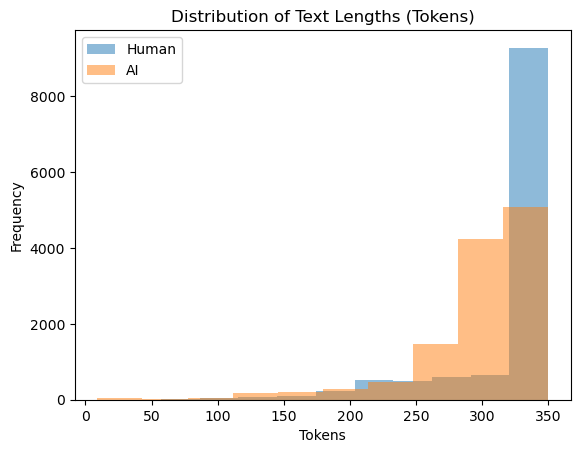

In [105]:

enc = tiktoken.get_encoding("cl100k_base")

# Count tokens instead of words
df['human_token_len'] = df['human_text_350'].apply(
    lambda x: len(enc.encode(x)) if isinstance(x, str) else None
)

df['ai_token_len'] = df['ai_text_350'].apply(
    lambda x: len(enc.encode(x)) if isinstance(x, str) else None
)

# Plot token distributions
plt.hist(df['human_token_len'].dropna(), alpha=0.5, label='Human')
plt.hist(df['ai_token_len'].dropna(), alpha=0.5, label='AI')
plt.legend()
plt.title("Distribution of Text Lengths (Tokens)")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()


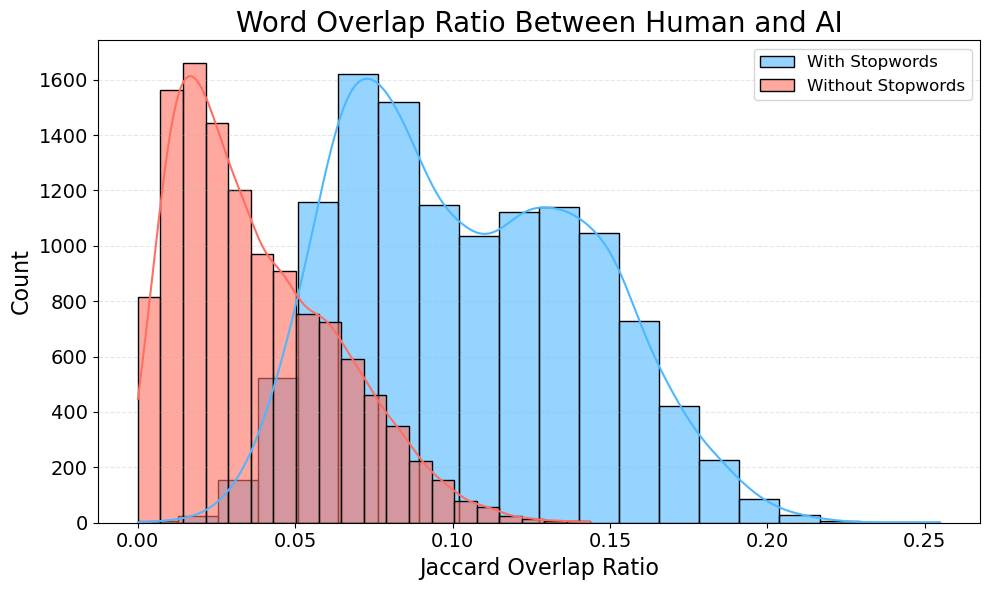

In [106]:
stop_words = set(stopwords.words("english"))

# פונקציה: overlap בלי stopwords
def word_overlap_no_stopwords(h, a):
    h_words = set(w for w in str(h).split() if w.lower() not in stop_words)
    a_words = set(w for w in str(a).split() if w.lower() not in stop_words)
    if not h_words or not a_words:
        return 0
    return len(h_words & a_words) / len(h_words | a_words)

# פונקציה: overlap כולל stopwords
def word_overlap(h, a):
    h_set = set(str(h).split())
    a_set = set(str(a).split())
    if not h_set or not a_set:
        return 0
    return len(h_set & a_set) / len(h_set | a_set)

# חישוב
overlap_with = df.apply(lambda row: word_overlap(row["human_text_350"], row["ai_text_350"]), axis=1)
overlap_no_stop = df.apply(lambda row: word_overlap_no_stopwords(row["human_text_350"], row["ai_text_350"]), axis=1)

# --- Plot ---
plt.figure(figsize=(10,6))
sns.histplot(overlap_with, bins=20, kde=True, color="#4DB8FF", label="With Stopwords", alpha=0.6)
sns.histplot(overlap_no_stop, bins=20, kde=True, color="#FF6F61", label="Without Stopwords", alpha=0.6)

plt.title("Word Overlap Ratio Between Human and AI", fontsize=20)
plt.xlabel("Jaccard Overlap Ratio", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

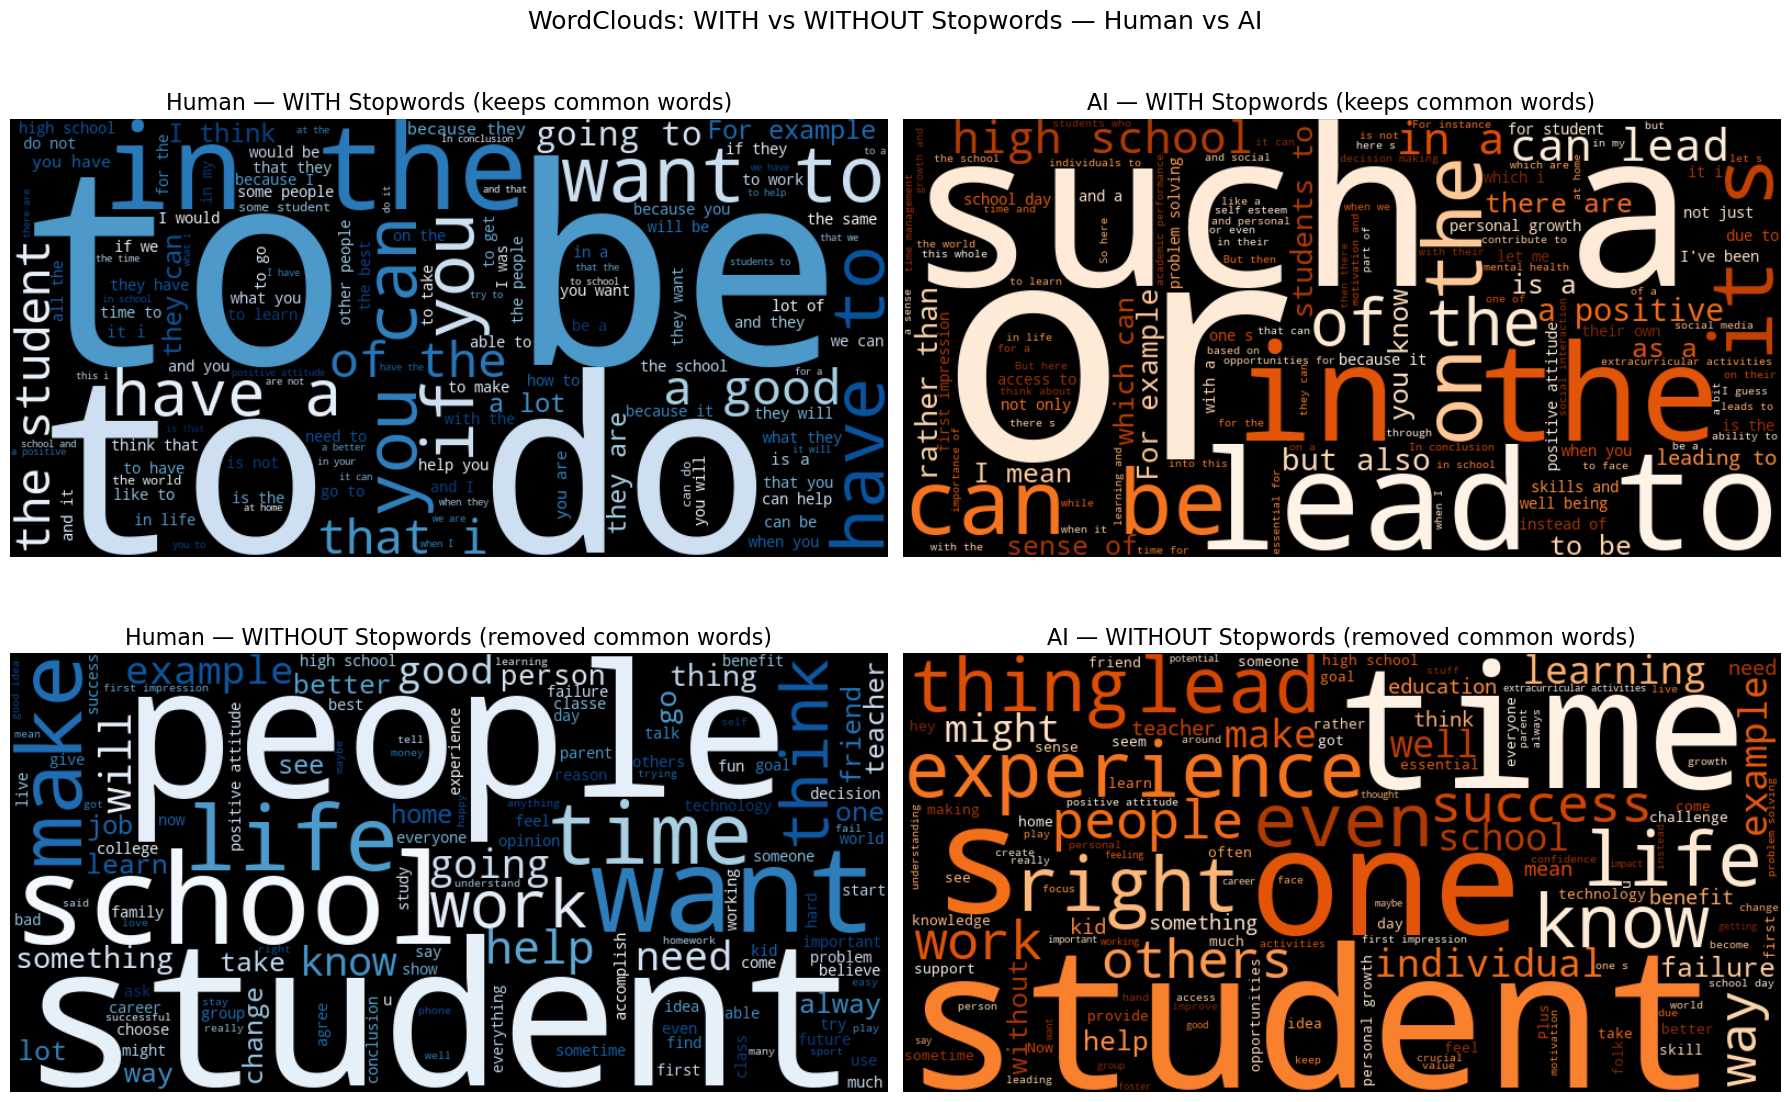

In [107]:

# --- Parameters you can change ---
# אם הטקסטים שלך בעברית, תחליף english_stopwords ברשימת stopwords בעברית
english_stopwords = set(STOPWORDS)   # standard english stopwords
use_collocations = True             # True = include bigrams; False = single-word only
random_state = 42
wc_width, wc_height = 800, 400
max_words = 120

# --- Prepare texts ---
human_text = " ".join(df['human_text_350'].dropna().astype(str))
ai_text    = " ".join(df['ai_text_350'].dropna().astype(str))

# --- Shared WordCloud params ---
base_params = dict(
    width=wc_width,
    height=wc_height,
    background_color="black",
    collocations=use_collocations,
    random_state=random_state,
    max_words=max_words
)

# --- Create 4 word clouds
# Note the naming: WITHOUT stopwords => we REMOVE stopwords => pass stopwords=english_stopwords
#           WITH stopwords    => we KEEP stopwords      => pass stopwords=set()
wc_human_withSW    = WordCloud(**base_params, colormap="Blues",   stopwords=set()).generate(human_text or " ")
wc_human_withoutSW = WordCloud(**base_params, colormap="Blues",   stopwords=english_stopwords).generate(human_text or " ")

wc_ai_withSW       = WordCloud(**base_params, colormap="Oranges", stopwords=set()).generate(ai_text or " ")
wc_ai_withoutSW    = WordCloud(**base_params, colormap="Oranges", stopwords=english_stopwords).generate(ai_text or " ")

# --- Plot 2x2 (top-left = WITH stopwords, bottom-left = WITHOUT stopwords) ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

axes[0,0].imshow(wc_human_withSW, interpolation="bilinear")
axes[0,0].set_title("Human — WITH Stopwords (keeps common words)", fontsize=16)
axes[0,0].axis("off")

axes[1,0].imshow(wc_human_withoutSW, interpolation="bilinear")
axes[1,0].set_title("Human — WITHOUT Stopwords (removed common words)", fontsize=16)
axes[1,0].axis("off")

axes[0,1].imshow(wc_ai_withSW, interpolation="bilinear")
axes[0,1].set_title("AI — WITH Stopwords (keeps common words)", fontsize=16)
axes[0,1].axis("off")

axes[1,1].imshow(wc_ai_withoutSW, interpolation="bilinear")
axes[1,1].set_title("AI — WITHOUT Stopwords (removed common words)", fontsize=16)
axes[1,1].axis("off")

plt.suptitle("WordClouds: WITH vs WITHOUT Stopwords — Human vs AI", fontsize=18)
plt.tight_layout()
plt.show()

C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_51048\3668757483.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


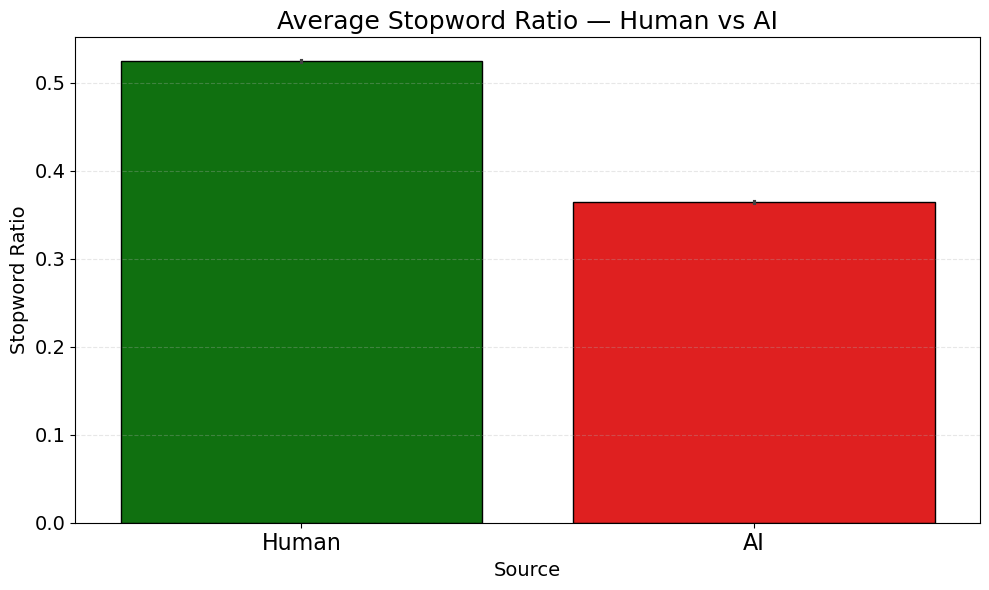

In [108]:
stop_words = set(stopwords.words("english"))

def stopword_ratio(text):
    words = text.split()
    if len(words)==0: return 0
    return sum(1 for w in words if w.lower() in stop_words)/len(words)

df_stop = pd.DataFrame({
    "Human": df["human_text_350"].fillna("").astype(str).map(stopword_ratio),
    "AI": df["ai_text_350"].fillna("").astype(str).map(stopword_ratio),
})

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_stop.melt(var_name="source", value_name="stopword_ratio"), 
    x="source", 
    y="stopword_ratio", 
    palette=["green","red"],  # ירוק ל-Human, אדום ל-AI
    edgecolor="black"
)
plt.title("Average Stopword Ratio — Human vs AI", fontsize=18)
plt.ylabel("Stopword Ratio", fontsize=14)
plt.xlabel("Source", fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1800x800 with 0 Axes>

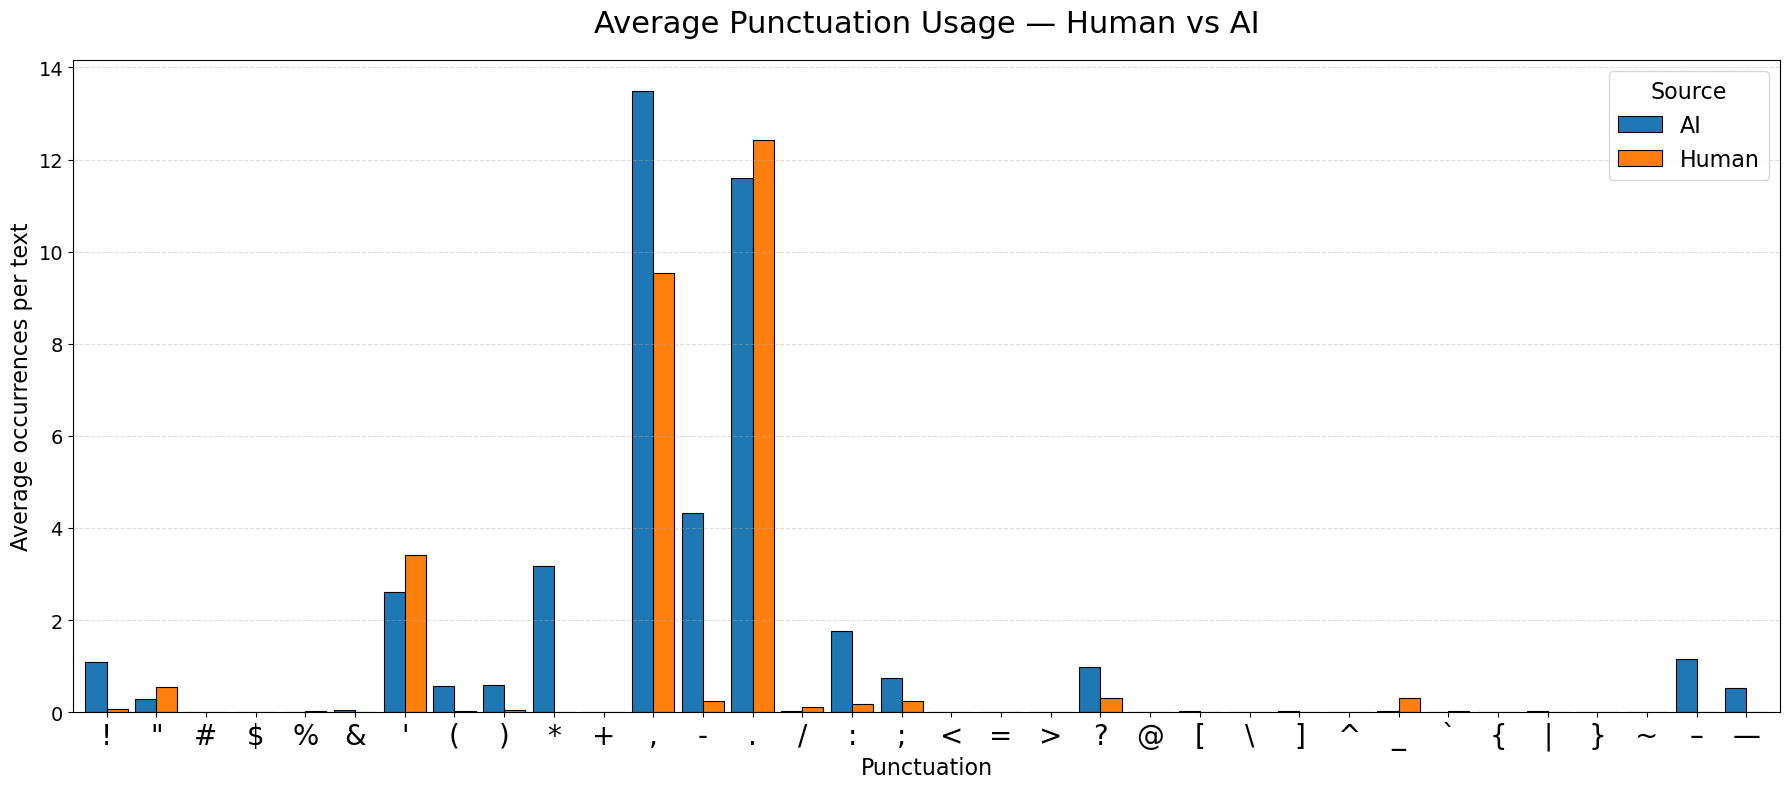

In [109]:

# -------------------------
# Normalize DF into "source" + "text" structure (Human & AI)
# -------------------------
df_punct = pd.DataFrame({
    "source": ["Human"] * len(df) + ["AI"] * len(df),
    "text":   df["human_text_350"].fillna("").astype(str).tolist()
            + df["ai_text_350"].fillna("").astype(str).tolist()
})

# -------------------------
# Define punctuation char list (includes en dash & em dash)
# -------------------------
punctuations = string.punctuation + "–—"

# For plotting purposes, we capture readable names:
def safe_name(p):
    if p == "–": return "endash"
    if p == "—": return "emdash"
    return p

# -------------------------
# Count punctuation occurrences per text
# -------------------------
for p in punctuations:
    df_punct[f"count_{safe_name(p)}"] = df_punct["text"].str.count(re.escape(p))

# -------------------------
# Compute mean usage per punctuation per source
# -------------------------
punct_avg = (
    df_punct.groupby("source")[
        [col for col in df_punct.columns if col.startswith("count_")]
    ]
    .mean()
    .T
)

# Replace safe names back to real characters
punct_avg.index = (
    punct_avg.index.str.replace("count_", "", regex=False)
                   .str.replace("endash", "–", regex=False)
                   .str.replace("emdash", "—", regex=False)
)

# -------------------------
# Final high-quality plot
# -------------------------
plt.figure(figsize=(18, 8))
punct_avg.plot(
    kind="bar",
    figsize=(18, 8),
    width=0.85,
    edgecolor="black",
    linewidth=0.8
)

plt.title("Average Punctuation Usage — Human vs AI", fontsize=22, pad=20)
plt.ylabel("Average occurrences per text", fontsize=16)
plt.xlabel("Punctuation", fontsize=16)

plt.xticks(fontsize=20, rotation=0, ha="center")
plt.yticks(fontsize=14)
plt.legend(fontsize=16, title="Source", title_fontsize=16)

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [110]:

# נניח שיש לך df עם העמודות human_text ו-ai_response
# נמזג אותם ל-DF אחיד עם 'source' ו-'text'
df_ratio = pd.DataFrame({
    "source": ["Human"]*len(df) + ["AI"]*len(df),
    "text":   df["human_text_350"].fillna("").astype(str).tolist()
             + df["ai_text_350"].fillna("").astype(str).tolist()
})

# פונקציה שמחשבת unique word ratio
def unique_ratio(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

df_ratio["unique_ratio"] = df_ratio["text"].apply(unique_ratio)

# ממוצע לכל source
avg_unique_ratio = df_ratio.groupby("source")["unique_ratio"].mean().reset_index()
avg_unique_ratio.columns = ["source", "avg_unique_ratio"]

print(avg_unique_ratio)

  source  avg_unique_ratio
0     AI          0.730585
1  Human          0.476332


C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_51048\3754287975.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


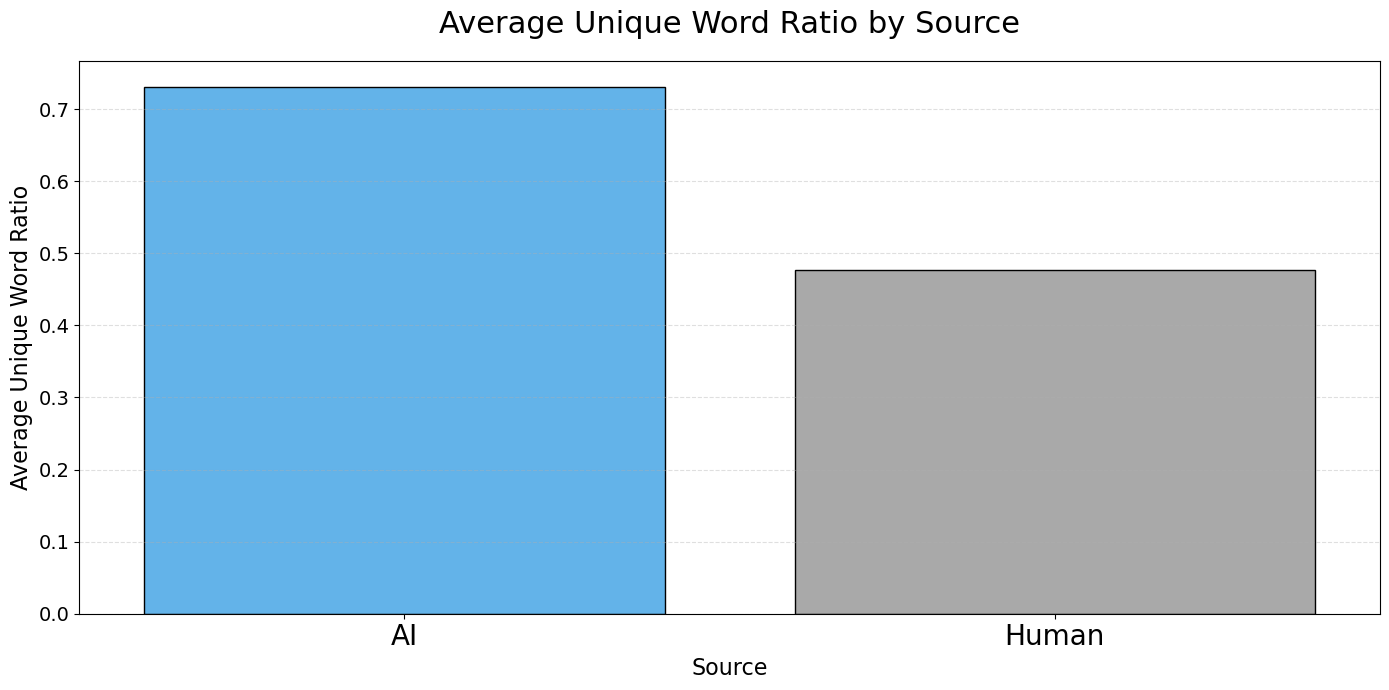

In [111]:
plt.figure(figsize=(14,7))
sns.barplot(
    data=avg_unique_ratio,
    x="source",
    y="avg_unique_ratio",
    palette=["#4DB8FF", "#A9A9A9"],  # תכלת ל-Human, אפור ל-AI
    edgecolor="black"
)

plt.title("Average Unique Word Ratio by Source", fontsize=22, pad=20)
plt.xlabel("Source", fontsize=16)
plt.ylabel("Average Unique Word Ratio", fontsize=16)
plt.xticks(fontsize=20, rotation=0, ha="center")
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



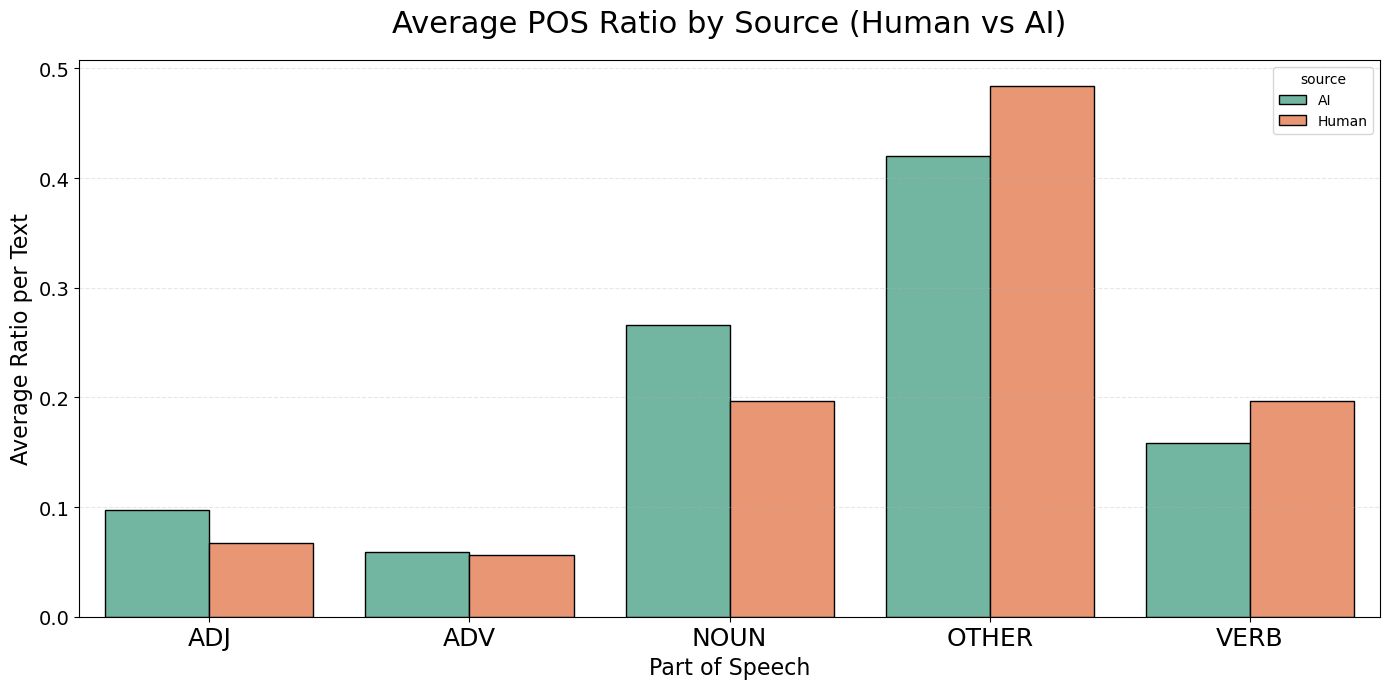

In [112]:

# --- POS Tagging Function ---
def get_pos_groups(text):
    """Return POS counts for a single text as a dict"""
    counts = {"NOUN":0, "VERB":0, "ADJ":0, "ADV":0, "OTHER":0}
    if not isinstance(text, str):
        return counts
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    for _, pos in tags:
        if pos.startswith("N"):
            counts["NOUN"] += 1
        elif pos.startswith("V"):
            counts["VERB"] += 1
        elif pos.startswith("J"):
            counts["ADJ"] += 1
        elif pos.startswith("R"):
            counts["ADV"] += 1
        else:
            counts["OTHER"] += 1
    return counts

# --- Prepare POS counts for Human and AI ---
records = []

for source_name, col in [("Human","human_text_350"), ("AI","ai_text_350")]:
    for t in df[col].dropna().astype(str):
        pos_counts = get_pos_groups(t)
        total_tokens = sum(pos_counts.values())
        # Compute ratio per POS
        for pos, count in pos_counts.items():
            ratio = count / total_tokens if total_tokens > 0 else 0
            records.append({"source": source_name, "pos": pos, "ratio": ratio})

pos_ratio_df = pd.DataFrame(records)

# --- Compute average ratio per POS per source ---
avg_pos_ratio = pos_ratio_df.groupby(["source","pos"])["ratio"].mean().reset_index()

# --- Plot ---
plt.figure(figsize=(14,7))
sns.barplot(
    data=avg_pos_ratio,
    x="pos",
    y="ratio",
    hue="source",
    palette="Set2",
    edgecolor="black"
)

plt.title("Average POS Ratio by Source (Human vs AI)", fontsize=22, pad=20)
plt.xlabel("Part of Speech", fontsize=16)
plt.ylabel("Average Ratio per Text", fontsize=16)

plt.xticks(fontsize=18)
plt.yticks(fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# Identifying optimal model

## Embeddings & Vectorization

### Data for embeddings

In [ ]:
df = pd.read_csv("ai_responses_progress.csv")
df = df[9000:16000]

enc = tiktoken.get_encoding("cl100k_base")

def truncate_to_n_tokens(text, n=350):
    if not isinstance(text, str):
        return text
    tokens = enc.encode(text)
    tokens = tokens[:n]
    return enc.decode(tokens)

df["human_text_350"] = df["human_text"].apply(lambda x: truncate_to_n_tokens(x,350))
df["ai_text_350"] = df["ai_response"].apply(lambda x: truncate_to_n_tokens(x, 350))

df = df[['instructions','human_text','ai_response','human_text_350','ai_text_350']]


# Keep instructions
df_human = df[["human_text_350", "instructions"]].copy()
df_human["label"] = 0  # human

df_ai = df[["ai_text_350", "instructions"]].copy()
df_ai["label"] = 1  # ai

# Rename columns
df_human.columns = ["text", "instructions", "label"]
df_ai.columns = ["text", "instructions", "label"]

# Combine
data = pd.concat([df_human, df_ai], ignore_index=True)
data = data.dropna().reset_index(drop=True)

texts = data["text"]
y = data["label"]
groups = data["instructions"]  # this will now work
data = data.dropna().reset_index(drop=True)


In [114]:
data

,text,instructions,label
0,"Yes, we are influenced by the people we see ev...",Task: Write an essay in which you discuss your...,0
1,Based on my experience people should be positi...,Task: Explain how incorporating positivity and...,0
2,Also some of them like to study but their pare...,Task: \n\n1. Research the advantages of school...,0
3,The devices were not made to harm others in ma...,Task: \n\n1. Research the positive and negativ...,0
4,When people buy stocks from other company is l...,Task: \n\nWrite an essay about how the growth ...,0
...,...,...,...
23995,"Outdoor adventures are a breath of fresh air, ...",Task: Write an essay on the importance of outd...,1
23996,I've been curious about what draws folks from ...,"Task: Research why people love to visit Korea,...",1
23997,"Hey there, I've gotta say that teaming up with...",Task: Task:\nExplore the benefits of working i...,1
23998,Hey everyone! I've been thinking a lot about t...,Task: Examine the benefits of having an age mi...,1


### TF IDF

In [115]:
tfidf_word = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=5,
    stop_words="english"
)

X_tfidf_word = tfidf_word.fit_transform(texts)

df_tfidf_word = pd.DataFrame.sparse.from_spmatrix(
    X_tfidf_word,
    columns=tfidf_word.get_feature_names_out()
)

df_tfidf_word["label"] = y.values

In [116]:
X_tfidf_word

<24000x148509 sparse matrix of type '<class 'numpy.float64'>'
	with 3880023 stored elements in Compressed Sparse Row format>

In [117]:
tfidf_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=5
)

X_tfidf_char = tfidf_char.fit_transform(texts)
y = y.values


In [118]:
X_tfidf_char

<24000x215369 sparse matrix of type '<class 'numpy.float64'>'
	with 68023781 stored elements in Compressed Sparse Row format>

### BOW

In [119]:
bow = CountVectorizer(
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=5,
    stop_words="english"
)

X_bow = bow.fit_transform(texts)


In [120]:
X_bow

<24000x148509 sparse matrix of type '<class 'numpy.int64'>'
	with 3880023 stored elements in Compressed Sparse Row format>

### W2V

In [15]:
# Tokenize texts
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# Train Word2Vec
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1  # skip-gram
)

# Function to average word vectors
def document_vector(doc):
    vectors = [
        w2v_model.wv[word]
        for word in doc
        if word in w2v_model.wv
    ]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

# Create document embeddings
X_w2v = np.vstack([document_vector(doc) for doc in tokenized_texts])

# Convert to DataFrame
df_w2v = pd.DataFrame(
    X_w2v,
    columns=[f"w2v_{i}" for i in range(X_w2v.shape[1])]
)
scaler = StandardScaler()

X_w2v_scaled = scaler.fit_transform(df_w2v)

df_w2v_scaled = pd.DataFrame(
    X_w2v_scaled,
    columns=df_w2v.columns
)

df_w2v_scaled["label"] = y

df_w2v_scaled

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,label
0,0.522671,2.006064,-0.684675,-0.401237,-0.126097,0.112429,0.381009,-0.732373,-0.645124,1.365908,...,0.082135,-1.328801,-0.459484,-1.834239,-1.281561,0.235955,2.927839,1.722676,-1.021374,0
1,1.482828,0.993819,-0.727499,-0.674024,0.539064,-1.550228,0.151207,-0.858023,0.646695,0.647740,...,1.741716,1.297883,0.167687,-0.886689,0.087411,-0.799530,-0.333050,-0.167725,0.060834,0
2,0.759372,-0.708918,0.205346,0.731342,1.173478,1.133026,-1.396455,1.467541,0.664131,-2.924655,...,-1.272231,-0.101052,-1.621985,-0.723709,-0.606660,-1.408628,-2.852332,2.642283,3.414701,0
3,0.894773,1.212317,-0.149463,-1.017280,0.415980,0.189752,0.216850,-0.016313,-0.327949,0.609111,...,-0.507042,1.259789,-0.513145,-1.141670,0.383193,0.321789,0.223550,-0.590207,-0.710642,0
4,0.885711,-0.104061,-0.752023,-0.067495,-0.160535,-0.026952,-1.537744,0.202847,-0.040060,-0.093840,...,-0.512162,-0.625602,-0.324750,-0.767373,-0.730333,-0.251536,-1.196743,-0.565762,1.144005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,-0.537555,1.510743,0.443616,1.334337,-0.592986,-0.125753,-0.498799,0.645941,0.961527,-0.259686,...,-1.018638,-1.112518,-0.047889,1.011770,-0.166742,-0.141697,0.999952,1.347063,-1.109532,1
13996,-0.279041,1.348495,1.599799,0.017185,-0.216552,-0.138517,-1.102823,0.287686,0.238615,1.372469,...,-0.837722,-1.464392,0.715406,0.682126,0.543421,0.850274,-0.139665,0.375062,-0.110262,1
13997,-0.402407,0.347625,0.204111,0.444577,-0.606180,-1.284288,-0.008852,0.303107,0.071931,0.258393,...,-0.562152,-0.510354,1.127212,0.666013,0.369295,2.314299,0.502504,0.378858,0.249346,1
13998,-0.129881,0.157304,0.769383,0.367232,-0.978643,-0.685502,1.501557,-0.726485,-0.068606,1.141683,...,0.559897,-0.613660,0.899962,0.564879,1.374641,0.445387,-0.091902,-0.870860,0.075451,1


### Custom Features

In [124]:
def get_top_words_combined(df, stopwords, top_k=20):
    words = []
    for text in df['text']:
        if pd.isna(text):
            continue
        text = str(text)
        # מילים באורך ≥2
        tokens = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
        tokens = [w for w in tokens if w not in stopwords]
        words.extend(tokens)
    # 10 המילים הכי נפוצות
    top_words = [w for w, _ in Counter(words).most_common(top_k)]
    return top_words

# הפעלה על כל הדאטה (HUMAN + AI יחד)
top_20_words = get_top_words_combined(data, STOPWORDS, top_k=20)
print("Top 10 most frequent words:", top_20_words)

Top 10 most frequent words: ['students', 'people', 'school', 'time', 'will', 'work', 'life', 'good', 'one', 'help', 'make', 'think', 'want', 'something', 'better', 'know', 'learning', 'things', 'need', 'don']


In [125]:
def extract_all_features(text, top_words):
    if pd.isna(text):
        text = ""
    text = str(text)
    words = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
    counts = Counter(words)
    total_words = len(words)
    unique_words = len(counts)
    probs = np.array(list(counts.values())) / total_words if total_words > 0 else np.array([1])

    # משפטים
    sentences = re.split(r'[.!?]', text)
    sentence_lengths = [len(s.split()) for s in sentences if s.strip()]

    features = {}

    # -------------------------
    # סטטיסטיים / טקסטואליים
    # -------------------------
    features["unique_word_ratio"] = unique_words / total_words if total_words > 0 else 0
    features["punctuation_ratio"] = sum(text.count(p) for p in punctuations) / max(1, len(text))
    features["capitalized_word_ratio"] = sum(w[0].isupper() for w in text.split() if w) / max(1, len(text.split()))
    features["digit_ratio"] = sum(c.isdigit() for c in text) / max(1, len(text))
    features["most_common_word_ratio"] = counts.most_common(1)[0][1] / total_words if total_words > 0 else 0
    features["entropy_words"] = entropy(probs)

    # -------------------------
    # One-Hot על המילים הנבחרות
    # -------------------------
    word_set = set(words)
    for w in top_words:
        features[f'has_{w}'] = int(w in word_set)

    return features

In [126]:
punctuations = string.punctuation
custom_vector_df = data['text'].apply(
    lambda x: extract_all_features(x, top_20_words)
).apply(pd.Series)

custom_vector_df['label'] = data['label'].values
custom_vector_df

,unique_word_ratio,punctuation_ratio,capitalized_word_ratio,digit_ratio,most_common_word_ratio,entropy_words,has_students,has_people,has_school,has_time,...,has_think,has_want,has_something,has_better,has_know,has_learning,has_things,has_need,has_don,label
0,0.423841,0.020085,0.092949,0.0,0.066225,4.397389,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.456140,0.024779,0.026846,0.0,0.056140,4.490354,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,0.295597,0.009861,0.045732,0.0,0.100629,4.077519,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0
3,0.518033,0.015651,0.052147,0.0,0.075410,4.650804,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,0.433121,0.015075,0.065625,0.0,0.044586,4.547132,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.717054,0.020434,0.052434,0.0,0.023256,5.053819,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1
23996,0.851351,0.018605,0.118421,0.0,0.033784,4.760094,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1
23997,0.717472,0.019888,0.060932,0.0,0.022305,5.117927,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
23998,0.727273,0.023291,0.075221,0.0,0.022727,4.951658,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1


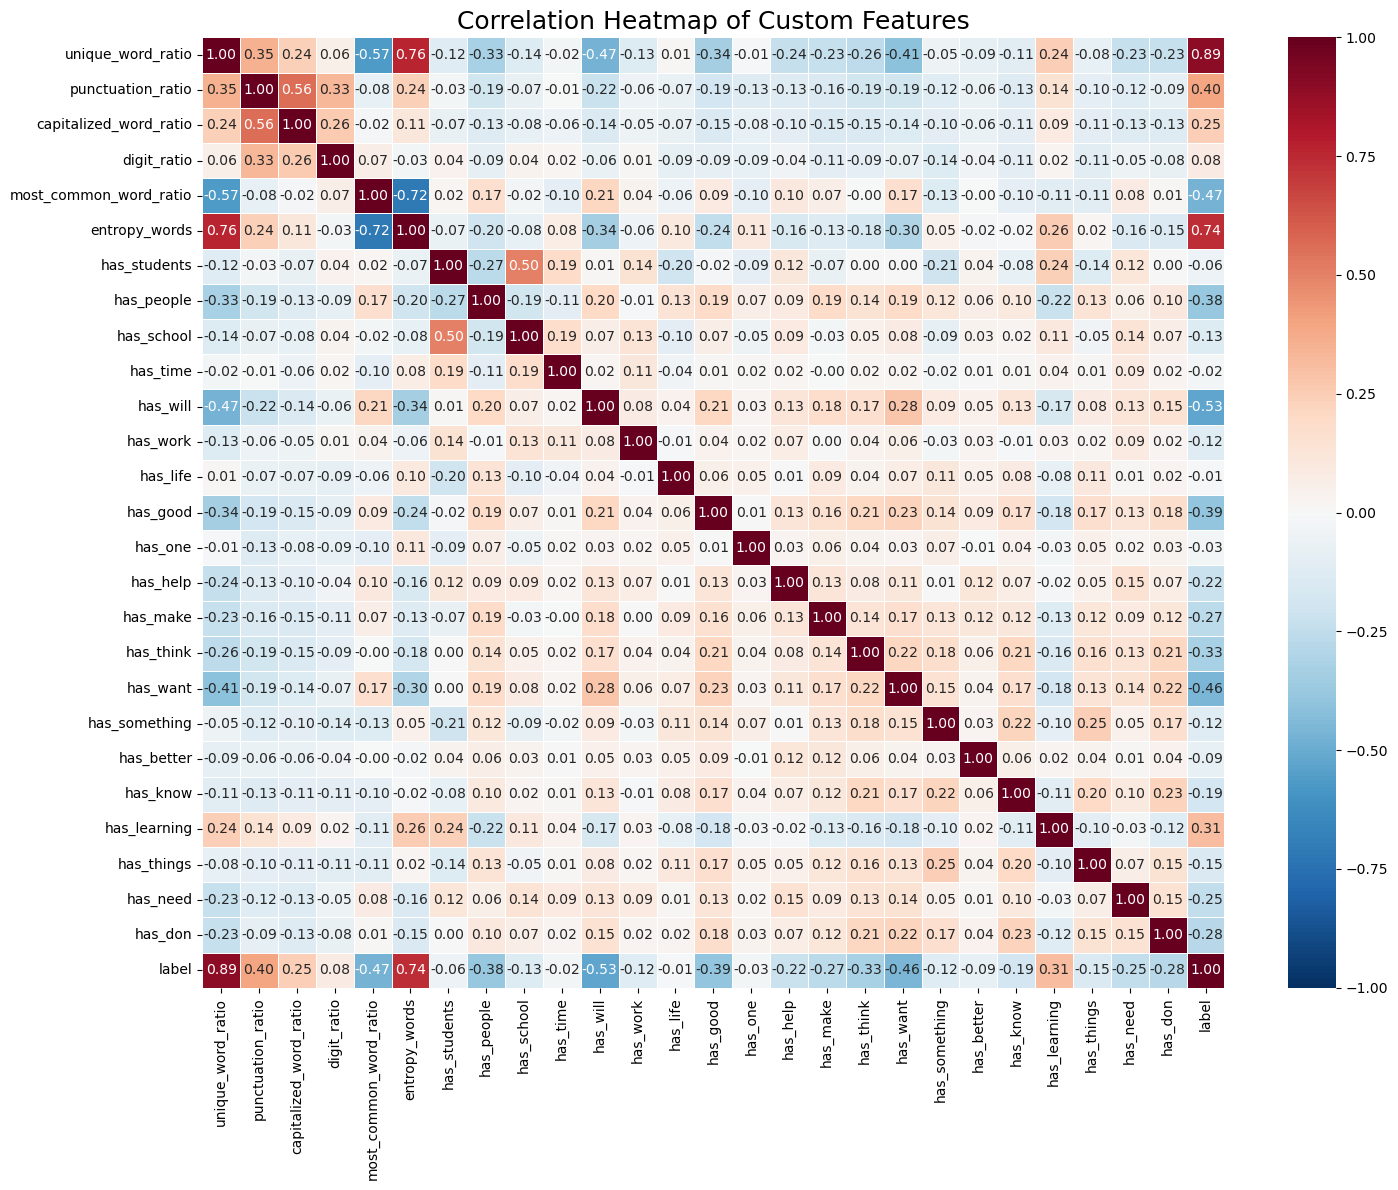

In [127]:
corr_matrix = custom_vector_df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(
    corr_matrix,
    annot=True,            # להוסיף את ערכי הקורלציה בתאים
    fmt=".2f",             # פורמט עם 2 ספרות אחרי הנקודה
    cmap="RdBu_r",          # אדום–כחול הפוך: כחול=שלילי, אדום=חיובי
    vmin=-1, vmax=1,       # תחום הקורלציה
    center=0,              # מרכז הצבע = 0
    linewidths=0.5         # קווים בין התאים
)
plt.title("Correlation Heatmap of Custom Features", fontsize=18)
plt.tight_layout()
plt.show()

## Modeling

### LogisticRegression

In [10]:
# --- Custom Features ---
X_custom = custom_vector_df.drop(columns=['label'])
y_custom = custom_vector_df['label']

scores_custom = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_custom,
    y_custom,
    cv=5,
    scoring="accuracy"
)
print("Custom Features CV accuracy:", scores_custom.mean())

# --- Word2Vec ---
X_w2v = df_w2v_scaled.drop(columns=['label'])
y_w2v = df_w2v_scaled['label']

scores_w2v = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_w2v,
    y_w2v,
    cv=5,
    scoring="accuracy"
)
print("Word2Vec CV accuracy:", scores_w2v.mean())

# --- Bag of Words ---
scores_bow = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_bow,
    y,
    cv=5,
    scoring="accuracy"
)
print("Bag of Words CV accuracy:", scores_bow.mean())

# --- TF-IDF Word ---
scores_tfidf_word = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_tfidf_word,
    y,
    cv=5,
    scoring="accuracy"
)
acc_tfidf_word = scores_tfidf_word.mean()
print("TF-IDF Word CV accuracy:", acc_tfidf_word)

# --- TF-IDF Char ---
scores_tfidf_char = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_tfidf_char,
    y,
    cv=5,
    scoring="accuracy"
)
acc_tfidf_char = scores_tfidf_char.mean()
print("TF-IDF Char CV accuracy:", acc_tfidf_char)

NameError: name 'custom_vector_df' is not defined

In [129]:
# יצירת טבלת LR עם עמודת Model
results = pd.DataFrame({
    "Representation": ["Custom Features", "Word2Vec", "Bag of Words", "TF-IDF Word", "TF-IDF Char"],
    "Accuracy": [
        scores_custom.mean(),
        scores_w2v.mean(),
        scores_bow.mean(),
        acc_tfidf_word,
        acc_tfidf_char
    ],
    "Model": ["Logistic Regression"] * 5  # מוסיפים עמודת Model
})

# מיון לפי Accuracy
results = results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

results

,Representation,Accuracy,Model
0,Bag of Words,0.999542,Logistic Regression
1,Word2Vec,0.999292,Logistic Regression
2,TF-IDF Char,0.999208,Logistic Regression
3,TF-IDF Word,0.998458,Logistic Regression
4,Custom Features,0.990833,Logistic Regression


In [130]:
def evaluate_model(X, y, title):
    model = LogisticRegression(max_iter=1000)

    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    print(f"{title} CV accuracy:", scores.mean())

    y_pred = cross_val_predict(model, X, y, cv=5)

    cm = confusion_matrix(y, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

Custom Features CV accuracy: 0.9908333333333333


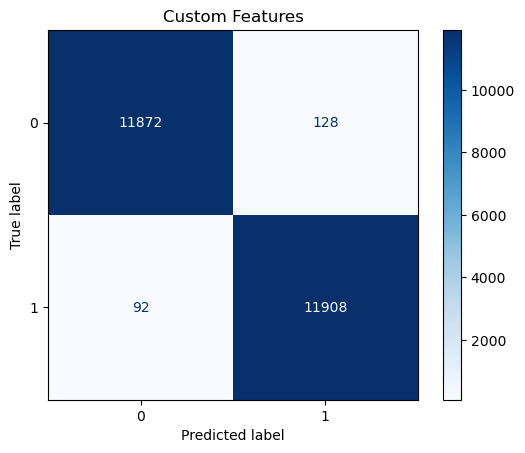

In [131]:
X_custom = custom_vector_df.drop(columns=['label'])
y_custom = custom_vector_df['label']

evaluate_model(X_custom, y_custom, "Custom Features")


Word2Vec CV accuracy: 0.9992916666666666


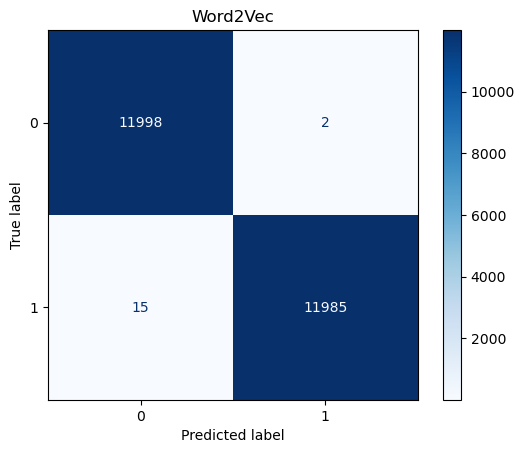

In [132]:
X_w2v = df_w2v_scaled.drop(columns=['label'])
y_w2v = df_w2v_scaled['label']

evaluate_model(X_w2v, y_w2v, "Word2Vec")


Bag of Words CV accuracy: 0.9995416666666668


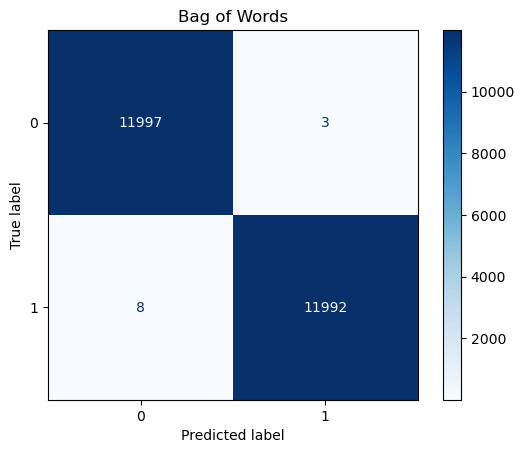

In [133]:
evaluate_model(X_bow, y, "Bag of Words")


TF-IDF Word CV accuracy: 0.9984583333333333


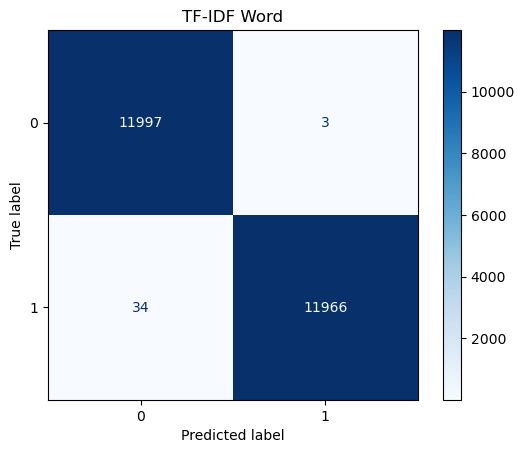

In [134]:
evaluate_model(X_tfidf_word, y, "TF-IDF Word")


TF-IDF Char CV accuracy: 0.9992083333333334


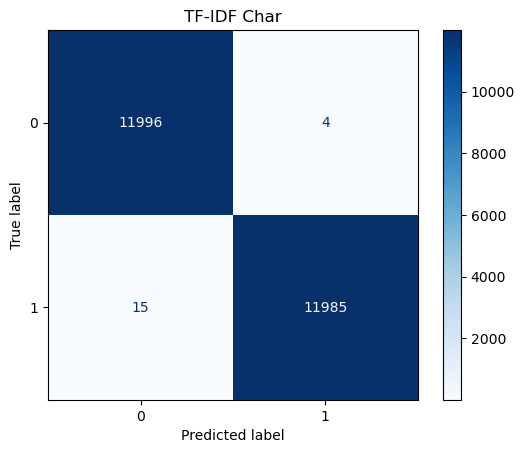

In [135]:
evaluate_model(X_tfidf_char, y, "TF-IDF Char")


### XGboost

In [136]:
def evaluate_xgboost(X, y, title):
    model = XGBClassifier(
        n_estimators=50,       
        max_depth=3,           
        learning_rate=0.2,
        subsample=1.0,
        colsample_bytree=1.0,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1              
    )


    scores = cross_val_score(model, X, y, cv=3, scoring="accuracy")
    print(f"{title} (XGBoost FAST) CV accuracy:", scores.mean())

    y_pred = cross_val_predict(model, X, y, cv=3)

    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{title} - XGBoost FAST")
    plt.show()

Custom Features (XGBoost FAST) CV accuracy: 0.9960833333333333


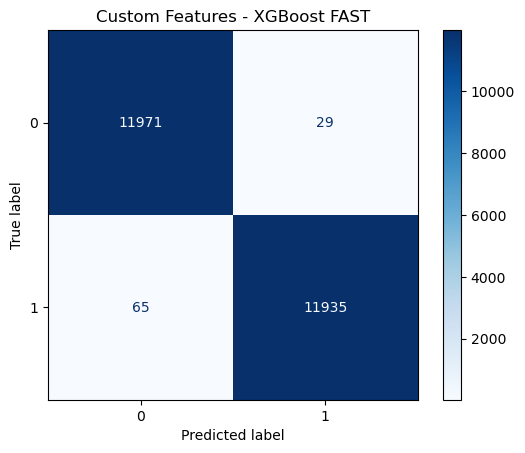

In [137]:
X_custom = custom_vector_df.drop(columns=['label'])
y_custom = custom_vector_df['label']

evaluate_xgboost(X_custom, y_custom, "Custom Features")


Word2Vec (XGBoost FAST) CV accuracy: 0.9962916666666667


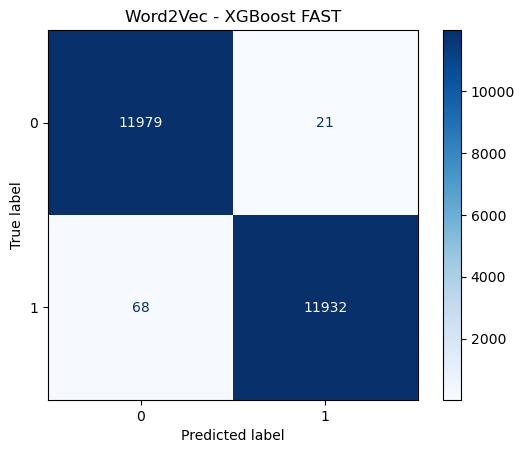

In [138]:
X_w2v = df_w2v_scaled.drop(columns=['label'])
y_w2v = df_w2v_scaled['label']

evaluate_xgboost(X_w2v, y_w2v, "Word2Vec")


Bag of Words (XGBoost FAST) CV accuracy: 0.98375


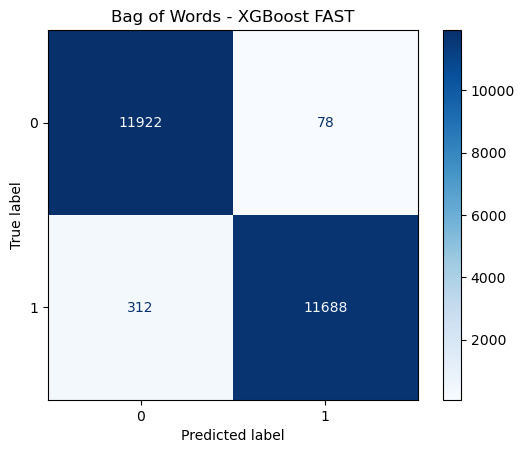

In [139]:
evaluate_xgboost(X_bow, y, "Bag of Words")


TF-IDF Word (XGBoost FAST) CV accuracy: 0.98625


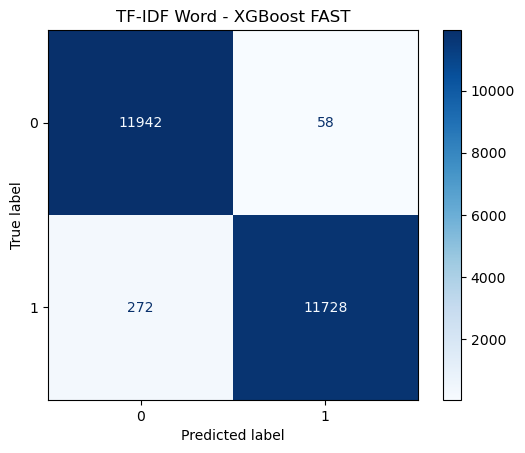

In [140]:
evaluate_xgboost(X_tfidf_word, y, "TF-IDF Word")


TF-IDF Char (XGBoost FAST) CV accuracy: 0.9987083333333334


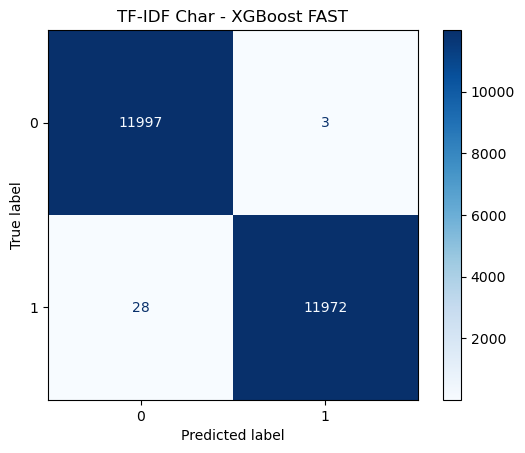

In [141]:
evaluate_xgboost(X_tfidf_char, y, "TF-IDF Char")


In [142]:
# ==========================
# XGBoost
# ==========================

# --- Custom Features ---
scores_xgb = {}
scores_xgb["Custom Features"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_custom, y_custom, cv=3, scoring="accuracy"
).mean()

# --- Word2Vec ---
scores_xgb["Word2Vec"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_w2v, y_w2v, cv=3, scoring="accuracy"
).mean()

# --- Bag of Words ---
scores_xgb["Bag of Words"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_bow, y, cv=3, scoring="accuracy"
).mean()

# --- TF-IDF Word ---
scores_xgb["TF-IDF Word"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_tfidf_word, y, cv=3, scoring="accuracy"
).mean()

# --- TF-IDF Char ---
scores_xgb["TF-IDF Char"] = cross_val_score(
    XGBClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.2,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),
    X_tfidf_char, y, cv=3, scoring="accuracy"
).mean()

In [143]:
# ==========================
# יצירת טבלת תוצאות מסודרת
# ==========================

xgb_df = pd.DataFrame([
    {"Model": "XGBoost", "Features": k, "Accuracy": v}
    for k, v in scores_xgb.items()
]).sort_values(
    by="Accuracy", ascending=False
).reset_index(drop=True)

# הצגת הטבלה
print("XGBoost – Cross Validation Accuracy Results")
xgb_df

XGBoost – Cross Validation Accuracy Results


,Model,Features,Accuracy
0,XGBoost,TF-IDF Char,0.998708
1,XGBoost,Word2Vec,0.996292
2,XGBoost,Custom Features,0.996083
3,XGBoost,TF-IDF Word,0.986250
4,XGBoost,Bag of Words,0.983750


In [144]:
features = ["Custom Features", "Word2Vec", "Bag of Words", "TF-IDF Word", "TF-IDF Char"]

# רשימת Accuracy של LR
lr_acc = [
    scores_custom.mean(),
    scores_w2v.mean(),
    scores_bow.mean(),
    acc_tfidf_word,
    acc_tfidf_char
]

# רשימת Accuracy של XGBoost (מהטבלה xgb_df)
xgb_acc = [xgb_df.loc[xgb_df["Features"] == f, "Accuracy"].values[0] for f in features]

# בנייה של טבלת long format
combined_long = pd.DataFrame({
    "Representation": features * 2,           # כל פיצ'ר מופיע פעמיים
    "Model": ["Logistic Regression"] * 5 + ["XGBoost"] * 5,
    "Accuracy": lr_acc + xgb_acc
})


combined_long = combined_long.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

combined_long

,Representation,Model,Accuracy
0,Bag of Words,Logistic Regression,0.999542
1,Word2Vec,Logistic Regression,0.999292
2,TF-IDF Char,Logistic Regression,0.999208
3,TF-IDF Char,XGBoost,0.998708
4,TF-IDF Word,Logistic Regression,0.998458
5,Word2Vec,XGBoost,0.996292
6,Custom Features,XGBoost,0.996083
7,Custom Features,Logistic Regression,0.990833
8,TF-IDF Word,XGBoost,0.986250
9,Bag of Words,XGBoost,0.983750


# Finale model

## Model creation

In [ ]:
df = pd.read_csv("ai_responses_progress.csv")
df = df[9000:16000]

enc = tiktoken.get_encoding("cl100k_base")

def truncate_to_n_tokens(text, n=350):
    if not isinstance(text, str):
        return text
    tokens = enc.encode(text)
    tokens = tokens[:n]
    return enc.decode(tokens)

df["human_text_350"] = df["human_text"].apply(lambda x: truncate_to_n_tokens(x,350))
df["ai_text_350"] = df["ai_response"].apply(lambda x: truncate_to_n_tokens(x, 350))

df = df[['instructions','human_text','ai_response','human_text_350','ai_text_350']]


# Keep instructions
df_human = df[["human_text_350", "instructions"]].copy()
df_human["label"] = 0  # human

df_ai = df[["ai_text_350", "instructions"]].copy()
df_ai["label"] = 1  # ai

# Rename columns
df_human.columns = ["text", "instructions", "label"]
df_ai.columns = ["text", "instructions", "label"]

# Combine
data = pd.concat([df_human, df_ai], ignore_index=True)
data = data.dropna().reset_index(drop=True)

texts = data["text"]
y = data["label"]
groups = data["instructions"]  # this will now work
data = data.dropna().reset_index(drop=True)


In [ ]:
# Tokenize texts
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# Train Word2Vec
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1  # skip-gram
)

# Function to average word vectors
def document_vector(doc):
    vectors = [
        w2v_model.wv[word]
        for word in doc
        if word in w2v_model.wv
    ]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

# Create document embeddings
X_w2v = np.vstack([document_vector(doc) for doc in tokenized_texts])

# Convert to DataFrame
df_w2v = pd.DataFrame(
    X_w2v,
    columns=[f"w2v_{i}" for i in range(X_w2v.shape[1])]
)
scaler = StandardScaler()

X_w2v_scaled = scaler.fit_transform(df_w2v)

df_w2v_scaled = pd.DataFrame(
    X_w2v_scaled,
    columns=df_w2v.columns
)

df_w2v_scaled["label"] = y

df_w2v_scaled

In [ ]:
X_w2v = df_w2v_scaled.drop(columns=['label'])
y_w2v = df_w2v_scaled['label']
# Train final classifier on ALL data
clf_w2v = LogisticRegression(max_iter=1000)
clf_w2v.fit(X_w2v_scaled, y_w2v)

In [ ]:
# Map numeric labels to your new names
label_names = {
    0: "Human",
    1: "AI"
}

def predict_text_w2v(text):
    tokens = word_tokenize(text.lower())

    vectors = [
        w2v_model.wv[word]
        for word in tokens
        if word in w2v_model.wv
    ]

    doc_vec = (
        np.mean(vectors, axis=0)
        if vectors else
        np.zeros(w2v_model.vector_size)
    )

    doc_vec = doc_vec.reshape(1, -1)

    # Keep feature names to avoid warning
    doc_vec_df = pd.DataFrame(doc_vec, columns=df_w2v.columns)
    doc_vec_scaled = scaler.transform(doc_vec_df)

    # Predict
    pred_numeric = clf_w2v.predict(doc_vec_scaled)[0]
    probs = clf_w2v.predict_proba(doc_vec_scaled)[0]

    # Human-readable prediction
    pred_label = label_names[pred_numeric]

    print("\nClass probabilities:")
    for num_label, prob in zip(clf_w2v.classes_, probs):
        print(f"{label_names[num_label]}: {prob*100:.2f}%")

    confidence = probs.max() * 100
    print(f"\nFinal prediction: {pred_label} ({confidence:.2f}% confidence)")

    return pred_label, probs


## Evaluation

### AI prediction

In [24]:
ESSAY_TOPICS = [
    "A moment that completely changed how you see the world",
    "Why boredom is actually important",
    "Something people pretend to understand but usually don't",
    "A small decision that had big consequences",
    "Why modern life feels overwhelming",
    "An opinion you changed your mind about",
    "The problem with being productive all the time",
    "Why nostalgia is dangerous",
    "What social media does to friendships",
    "Why people romanticize the past",

    "A time you were confidently wrong",
    "What nobody tells you about growing up",
    "Why silence makes people uncomfortable",
    "How routines quietly shape who we are",
    "Why people are afraid of being average",
    "The pressure to always have an opinion",
    "Why convenience is making life worse",
    "What failure actually teaches",
    "Why people miss things they never had",
    "How expectations ruin experiences",

    "Why being busy feels safer than being honest",
    "The difference between being alone and being lonely",
    "Why people avoid difficult conversations",
    "How habits slowly become identity",
    "Why first impressions matter too much",
    "What it means to feel behind in life",
    "Why people chase motivation instead of discipline",
    "The emotional cost of constant comparison",
    "Why people confuse confidence with certainty",
    "How comfort zones quietly shrink",

    "Why apologies are harder than they seem",
    "What people misunderstand about happiness",
    "Why choice can be exhausting",
    "How technology changes attention",
    "Why people fear being forgotten",
    "The quiet pressure to be successful",
    "Why people resist changing their minds",
    "How small habits reveal big values",
    "Why people avoid silence",
    "What disappointment teaches about expectations",

    "Why people overestimate their self-awareness",
    "How memory reshapes the past",
    "Why people struggle to rest without guilt",
    "The illusion of being productive",
    "Why people miss closure",
    "How identity shifts over time",
    "Why people romanticize struggle",
    "What it means to outgrow something",
    "Why people fear slowing down",
    "The problem with chasing potential",

    "Why people mistake busyness for purpose",
    "How fear disguises itself as logic",
    "Why people hold onto outdated beliefs",
    "The emotional weight of unfinished things",
    "Why people resist boredom",
    "How expectations shape disappointment",
    "Why people confuse comfort with happiness",
    "The subtle cost of convenience",
    "Why people fear being misunderstood",
    "How routine dulls awareness",

    "Why people avoid uncertainty",
    "What people get wrong about confidence",
    "Why people cling to familiarity",
    "The hidden impact of small choices",
    "Why people struggle with patience",
    "How social norms shape behavior",
    "Why people fear change even when unhappy",
    "The difference between growth and pressure",
    "Why people avoid introspection",
    "How modern life fragments attention",
    "Why people confuse movement with progress",
    "How comfort can quietly limit growth",
    "Why people avoid saying what they really mean",
    "The emotional impact of always being reachable",
    "Why people fear wasting time more than wasting energy",
    "How small disappointments accumulate over time",
    "Why people struggle to sit with uncertainty",
    "The difference between distraction and rest",
    "Why people resist changing routines that no longer help",
    "How expectations shape self-worth",

    "Why people mistake intensity for importance",
    "The quiet influence of social approval",
    "Why people delay decisions they already made emotionally",
    "How familiarity creates blind spots",
    "Why people avoid admitting they were wrong",
    "The cost of constantly optimizing life",
    "Why people fear missing out more than missing meaning",
    "How comparison subtly distorts self-image",
    "Why people feel guilty for slowing down",
    "The emotional weight of unfinished conversations",

    "Why people confuse being needed with being valued",
    "How modern life discourages patience",
    "Why people avoid confronting their own patterns",
    "The hidden pressure to appear confident",
    "Why people struggle to define success for themselves",
    "How silence exposes uncomfortable thoughts",
    "Why people cling to certainty in uncertain situations",
    "The difference between coping and healing",
    "Why people resist letting go of familiar discomfort",
    "How constant stimulation weakens attention"
]

In [ ]:
client = OpenAI(api_key="API_KEY_HERE")


df_test = pd.DataFrame({
    "instruction": [f"Write a reflective essay about: {t}" for t in ESSAY_TOPICS],
    "ai_response": [None] * len(ESSAY_TOPICS)
})

for i, prompt in enumerate(df_test["instruction"]):
    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "Write like a human, no markdown or lists, natural tone."},
                {"role": "user", "content": prompt}
            ],
            max_completion_tokens=350
        )
        df_test.at[i, "ai_response"] = response.choices[0].message.content.strip()
        print(f"Generated essay {i+1}/{len(df_test)}")
    except Exception as e:
        print(f"Failed to generate essay {i}: {e}")
        df_test.at[i, "ai_response"] = "[FAILED]"

df_test.to_csv("ai_test.csv", index=False)


Generated essay 1/100
Generated essay 2/100
Generated essay 3/100
Generated essay 4/100
Generated essay 5/100
Generated essay 6/100
Generated essay 7/100
Generated essay 8/100
Generated essay 9/100
Generated essay 10/100
Generated essay 11/100
Generated essay 12/100
Generated essay 13/100
Generated essay 14/100
Generated essay 15/100
Generated essay 16/100
Generated essay 17/100
Generated essay 18/100
Generated essay 19/100
Generated essay 20/100
Generated essay 21/100
Generated essay 22/100
Generated essay 23/100
Generated essay 24/100
Generated essay 25/100
Generated essay 26/100
Generated essay 27/100
Generated essay 28/100
Generated essay 29/100
Generated essay 30/100
Generated essay 31/100
Generated essay 32/100
Generated essay 33/100
Generated essay 34/100
Generated essay 35/100
Generated essay 36/100
Generated essay 37/100
Generated essay 38/100
Generated essay 39/100
Generated essay 40/100
Generated essay 41/100
Generated essay 42/100
Generated essay 43/100
Generated essay 44/1

In [27]:
df_test = pd.read_csv("ai_test.csv")


In [28]:
df_test

,instruction,ai_response
0,Write a reflective essay about: A moment that ...,I remember the day like it was yesterday. The ...
1,Write a reflective essay about: Why boredom is...,"Boredom, an unwanted yet familiar companion, i..."
2,Write a reflective essay about: Something peop...,Title: The Enigma of Happiness: A Faux Compreh...
3,Write a reflective essay about: A small decisi...,Title: The Crossroads of Choice and Consequenc...
4,Write a reflective essay about: Why modern lif...,As I sit back and permit my mind to navigate t...
...,...,...
95,Write a reflective essay about: How silence ex...,"Silence, the absence of sound and incessant ch..."
96,Write a reflective essay about: Why people cli...,"Throughout my life, I’ve noticed that all huma..."
97,Write a reflective essay about: The difference...,The trials and tribulations of life often pres...
98,Write a reflective essay about: Why people res...,"Have you ever had a pair of old, worn-out shoe..."


In [ ]:
lst = []
for idx, row in df_test.iterrows():
    text = row['ai_response']
    label, probs = predict_text_w2v(text)
    lst.append(label)
lst


Class probabilities:
Human: 30.87%
AI: 69.13%

Final prediction: AI (69.13% confidence)

Class probabilities:
Human: 10.91%
AI: 89.09%

Final prediction: AI (89.09% confidence)

Class probabilities:
Human: 6.69%
AI: 93.31%

Final prediction: AI (93.31% confidence)

Class probabilities:
Human: 11.88%
AI: 88.12%

Final prediction: AI (88.12% confidence)

Class probabilities:
Human: 2.91%
AI: 97.09%

Final prediction: AI (97.09% confidence)

Class probabilities:
Human: 18.59%
AI: 81.41%

Final prediction: AI (81.41% confidence)

Class probabilities:
Human: 4.59%
AI: 95.41%

Final prediction: AI (95.41% confidence)

Class probabilities:
Human: 29.82%
AI: 70.18%

Final prediction: AI (70.18% confidence)

Class probabilities:
Human: 6.81%
AI: 93.19%

Final prediction: AI (93.19% confidence)

Class probabilities:
Human: 41.27%
AI: 58.73%

Final prediction: AI (58.73% confidence)

Class probabilities:
Human: 30.79%
AI: 69.21%

Final prediction: AI (69.21% confidence)

Class probabilities:
Hum

['AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI',
 'AI']

In [ ]:
count_ai = 0
for i in lst:
    if i == "AI":
        count_ai += 1

count_ai

0

### Real life Prediction

In [19]:
def collect_texts(filename="reddit_test.csv"):
    # If file exists → load it. If not → create empty DataFrame
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        print(f"Loaded {len(df)} existing rows.\n")
    else:
        df = pd.DataFrame(columns=['text'])
        print("No existing file found. Starting fresh.\n")
    
    # Collect new texts
    while True:
        user_input = input("Enter text (or type 'stop' to finish): ")
        if user_input.lower() == "stop":
            break
        
        # Append the new text
        df = pd.concat([df, pd.DataFrame({'text': [user_input]})], ignore_index=True)

    # Save the updated file
    df.to_csv(filename, index=False)
    print(f"\nSaved. Total rows now: {len(df)}")

    return df


In [ ]:
#df_twitter = collect_texts()
#df_twitter.to_csv("twitter_test.csv", index=False)
#df_twitter

,text
0,People are losing their personal freedom every...
1,It’s all so bogus. They can’t even keep foster...
2,I think the point of this outrage is justified...
3,Congratulations to Elon Musk and the xAI team ...
4,Absolutely a game changer. You can find possib...
5,"In recent years, trust in public health advice..."
6,Proposing Grok for public service communicatio...
7,I just don’t get how anyone seriously thinks r...
8,Well we all know what’s going on here it looks...
9,That story about Nikita Bier really captures t...


In [ ]:
#df_reddit = collect_texts()
#df_reddit.to_csv("reddit_test.csv", index=False)
#df_reddit


Loaded 19 existing rows.




Saved. Total rows now: 22


,text
0,a very underrated volume for me. this might be...
1,alking about demon slayer here (mainly its fan...
2,There actually are some anime with girls/women...
3,I promise you that whilst you won't finish a b...
4,That is a good reason to read books. Here are...
5,So. You could basically just murder everyone l...
6,I'm a pretty big fan of MHA. I started reading...
7,Given the several discussions here discussing ...
8,As the name implies this technique is based ar...
9,With the return of the anime and seeing how po...


In [ ]:
#df_linkdin = collect_texts()
#df_linkdin.to_csv("linkdin_test.csv", index=False)
#df_linkdin

Loaded 21 existing rows.



In [ ]:
#df_wiki = collect_texts()
#df_wiki.to_csv("wiki_test.csv", index=False)
#df_wiki

In [ ]:
df_twitter = pd.read_csv("twitter_test.csv")
df_reddit = pd.read_csv("reddit_test.csv")
df_linkdin = pd.read_csv("linkdin_test.csv")

In [ ]:
lst = []
human_count = 0

for idx, row in df_twitter.iterrows():
    text = row['text']
    label, probs = predict_text_w2v(text)   # label is "Human" or "AI"
    lst.append(label)
    
    if label.lower() == "human":
        human_count += 1

total = len(df_twitter)
percent_human = (human_count / total) * 100

print(f"Total texts: {total}")
print(f"Predicted human: {human_count}")
print(f"Percentage human: {percent_human:.2f}%")



Class probabilities:
Human: 55.43%
AI: 44.57%

Final prediction: Human (55.43% confidence)

Class probabilities:
Human: 99.58%
AI: 0.42%

Final prediction: Human (99.58% confidence)

Class probabilities:
Human: 95.92%
AI: 4.08%

Final prediction: Human (95.92% confidence)

Class probabilities:
Human: 99.94%
AI: 0.06%

Final prediction: Human (99.94% confidence)

Class probabilities:
Human: 96.48%
AI: 3.52%

Final prediction: Human (96.48% confidence)

Class probabilities:
Human: 98.48%
AI: 1.52%

Final prediction: Human (98.48% confidence)

Class probabilities:
Human: 98.03%
AI: 1.97%

Final prediction: Human (98.03% confidence)

Class probabilities:
Human: 70.61%
AI: 29.39%

Final prediction: Human (70.61% confidence)

Class probabilities:
Human: 99.97%
AI: 0.03%

Final prediction: Human (99.97% confidence)

Class probabilities:
Human: 80.06%
AI: 19.94%

Final prediction: Human (80.06% confidence)

Class probabilities:
Human: 94.91%
AI: 5.09%

Final prediction: Human (94.91% confiden

# Humanizer

## creating model

In [2]:
df = pd.read_csv("ai_responses_progress.csv")
df = df[:11000]

enc = tiktoken.get_encoding("cl100k_base")

def truncate_to_n_tokens(text, n=350):
    if not isinstance(text, str):
        return text
    tokens = enc.encode(text)
    tokens = tokens[:n]
    return enc.decode(tokens)

df["human_text_350"] = df["human_text"].apply(lambda x: truncate_to_n_tokens(x,350))
df["ai_text_350"] = df["ai_response"].apply(lambda x: truncate_to_n_tokens(x, 350))

df = df[['instructions','human_text','ai_response','human_text_350','ai_text_350']]
df

,instructions,human_text,ai_response,human_text_350,ai_text_350
0,Task: Write a persuasive essay on whether or n...,Also they feel more comfortable at home. Some ...,With the rapid advancement of technology and t...,Also they feel more comfortable at home. Some ...,With the rapid advancement of technology and t...
1,Task: Research the advantages and disadvantage...,"I can get another job to work on the weekends,...",The concept of a four-day school week has gain...,"I can get another job to work on the weekends,...",The concept of a four-day school week has gain...
2,Task: \n\n1. Talk to your parents before takin...,parents and school should agree on the desicio...,5. Make sure that activities you choose align ...,parents and school should agree on the desicio...,5. Make sure that activities you choose align ...
3,Task: Write an essay discussing the benefits o...,"Base in my experiences I'm growing, I try hard...","Ralph Waldo Emerson once said, “Do not go wher...","Base in my experiences I'm growing, I try hard...","Ralph Waldo Emerson once said, “Do not go wher..."
4,Task: Research and discuss how character trait...,Many people around the world have different ch...,Character traits in humans are formed through ...,Many people around the world have different ch...,Character traits in humans are formed through ...
...,...,...,...,...,...
10995,Task: Analyze the potential pros and cons of s...,"A regular school day is about 8 hours, meaning...",Hey everyone! Just been thinking about this wh...,"A regular school day is about 8 hours, meaning...",Hey everyone! Just been thinking about this wh...
10996,Task: Task:\nWrite an essay exploring the bene...,"for example, my brother who was doing somethin...","Alright folks, I want us all sitting up straig...","for example, my brother who was doing somethin...","Alright folks, I want us all sitting up straig..."
10997,Task: \n1. Examine the role of failure in purs...,"Not you, not me, even no one hits that hard li...","Alright, here goes: I've been pondering over t...","Not you, not me, even no one hits that hard li...","Alright, here goes: I've been pondering over t..."
10998,Task: Research and reflect on the role that fa...,I agree with Churchill's statement about the i...,"It’s okay not always getting things right, you...",I agree with Churchill's statement about the i...,"It’s okay not always getting things right, you..."


In [3]:
# Keep instructions
df_human = df[["human_text_350", "instructions"]].copy()
df_human["label"] = 0  # human

df_ai = df[["ai_text_350", "instructions"]].copy()
df_ai["label"] = 1  # ai

# Rename columns
df_human.columns = ["text", "instructions", "label"]
df_ai.columns = ["text", "instructions", "label"]

# Combine
data = pd.concat([df_human, df_ai], ignore_index=True)
data = data.dropna().reset_index(drop=True)

texts = data["text"]
y = data["label"]
groups = data["instructions"]  # this will now work
data = data.dropna().reset_index(drop=True)
data

sw = set(stopwords.words("english"))

# Function to remove stopwords from a string
def remove_stopwords(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # tokenize words
    words = re.findall(r"\b\w+\b", text.lower())
    # remove stopwords
    filtered = [w for w in words if w not in sw]
    return " ".join(filtered)

# Apply to your text column
data["text"] = data["text"].apply(remove_stopwords)

# Check the result
data


,text,instructions,label
0,also feel comfortable home school decreased bu...,Task: Write a persuasive essay on whether or n...,0
1,get another job work weekends thing would allo...,Task: Research the advantages and disadvantage...,0
2,parents school agree desicions wha going bette...,Task: \n\n1. Talk to your parents before takin...,0
3,base experiences growing try hard try convince...,Task: Write an essay discussing the benefits o...,0
4,many people around world different character t...,Task: Research and discuss how character trait...,0
...,...,...,...
21995,hey everyone thinking whole online schooling t...,Task: Analyze the potential pros and cons of s...,1
21996,alright folks want us sitting straight diving ...,Task: Task:\nWrite an essay exploring the bene...,1
21997,alright goes pondering whole failure leading s...,Task: \n1. Examine the role of failure in purs...,1
21998,okay always getting things right know like win...,Task: Research and reflect on the role that fa...,1


In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    data["text"], 
    data["label"], 
    test_size=0.2, 
    random_state=42,
    stratify=data["label"]
)


bow_word = CountVectorizer(
    analyzer="word",
    ngram_range=(3, 5),
    min_df=5
)

X_train_bow = bow_word.fit_transform(X_train)
X_test_bow = bow_word.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_bow, y_train)


LogisticRegression(max_iter=1000)

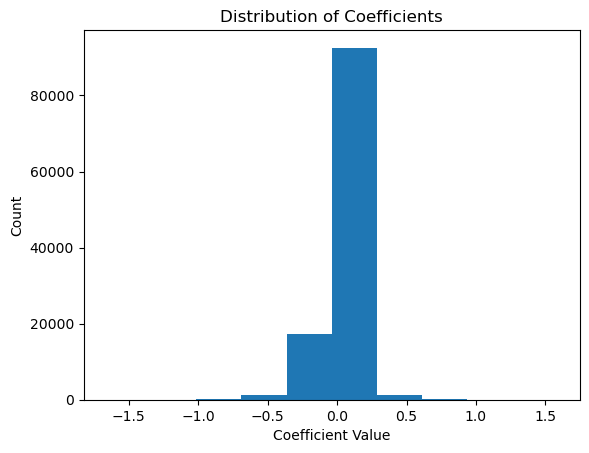

In [5]:

coef = clf.coef_[0]

plt.hist(coef)
plt.ylabel("Count")
plt.xlabel("Coefficient Value")
plt.title("Distribution of Coefficients")
plt.show()


In [6]:
import numpy as np
import re
from collections import defaultdict

coef = clf.coef_[0]
features = bow_word.get_feature_names_out()

word_scores = defaultdict(float)

for feat, weight in zip(features, coef):
    # extract words of 2+ letters
    words = re.findall(r"[A-Za-z]{2,}", feat)
    for w in words:
        word_scores[w.lower()] += weight

# Convert to sorted lists
sorted_words = sorted(word_scores.items(), key=lambda x: x[1])

top_negative_words = sorted_words[:20]
top_positive_words = sorted_words[-20:][::-1]

print("Top POSITIVE single words:")
for w, s in top_positive_words:
    print(w, s)

print("\nTop NEGATIVE single words:")
for w, s in top_negative_words:
    print(w, s)


Top POSITIVE single words:
personal 77.29595635736331
social 64.45752739030581
growth 56.45643253590795
skills 53.4758651627559
learning 49.13626592146954
individuals 47.755337867043124
often 41.58327346652549
academic 40.81037119624998
may 37.15415880239939
self 34.335003950380944
lead 33.86634669261265
health 32.92283893817991
face 31.922141506639427
benefits 30.507805236703753
offers 29.959790028673577
opportunities 29.64321672992363
challenges 29.503432000605148
solving 29.025622127729658
mental 28.398537128487945
communication 27.02744525787414

Top NEGATIVE single words:
people -384.9316589931089
school -232.76344577676727
good -215.39942912639202
get -178.02807525936112
want -167.83771115076226
would -166.8316357631603
help -161.17346482769122
like -158.5146557859956
make -149.65765919017264
students -148.4863842316742
work -143.04178544974198
think -136.036202529276
life -120.73924549075639
time -113.1380373717794
something -102.56186253170138
need -98.7791332522248
go -98.4367

## Pipline

In [ ]:
# =========================================================
# GLOBALS
# =========================================================
bow_word  # trained CountVectorizer (word-level)
clf       # trained classifier

# Preload stopwords
sw = set(stopwords.words("english"))

# Load sentence transformer for semantic similarity
sem_model = SentenceTransformer("all-MiniLM-L6-v2")

# Keep global memory of words/ngrams to avoid repeated risky phrases
global_avoid_words = set()
global_avoid_ngrams = set()

# =========================================================
# 1) CLASSIFIER PREDICTION (BoW)
# =========================================================
def predict_binary_bow(text: str) -> int:
    X = bow_word.transform([text])
    return int(clf.predict(X)[0])

# =========================================================
# 2) HARMFUL N-GRAM DETECTION
# =========================================================
def get_top_harmful_char_ngrams(text, vectorizer, classifier, top_k=10):
    """
    Improved BoW: normalize contributions by n-gram length and remove stop phrases.
    """
    X = vectorizer.transform([text])
    feature_names = vectorizer.get_feature_names_out()
    coefs = classifier.coef_[0]
    counts = X.toarray()[0]

    # normalize contribution by ngram length
    contributions = (counts * coefs) / np.maximum(1, np.array([len(f) for f in feature_names]))

    # top_k ngrams
    idx = contributions.argsort()[::-1][:top_k]
    harmful_ngrams = [feature_names[i] for i in idx]

    # remove common meaningless phrases
    stop_phrases = {"in the", "to be", "is the", "you need to", "i want to"}
    harmful_ngrams = [ng for ng in harmful_ngrams if ng not in stop_phrases]

    return harmful_ngrams

# =========================================================
# 3) HARMFUL WORD EXTRACTION
# =========================================================
def extract_harmful_words(text: str, vectorizer, classifier, top_k=20):
    """
    Extract alphabetic words from top harmful n-grams, filter stopwords.
    """
    harmful = get_top_harmful_char_ngrams(text, vectorizer, classifier, top_k)
    
    word_set = set()
    for ngram in harmful:
        words = re.findall(r"[A-Za-z]{3,}", ngram)
        for w in words:
            lw = w.lower()
            if lw not in sw:
                word_set.add(lw)
    return list(word_set)

# =========================================================
# 4) SEMANTIC SIMILARITY
# =========================================================
def semantic_similarity(a: str, b: str) -> float:
    if b is None or a.strip() == "":
        return 1.0
    emb1 = sem_model.encode(a, convert_to_tensor=True)
    emb2 = sem_model.encode(b, convert_to_tensor=True)
    return float(util.cos_sim(emb1, emb2)[0][0])

def is_similar(a: str, b: str, threshold: float = 0.90) -> bool:
    """
    Use semantic similarity instead of pure character matching.
    """
    return semantic_similarity(a, b) > threshold

# =========================================================
# 5) REWRITE WITH PHI3
# =========================================================
def rewrite_text_with_phi3(input_text: str, avoid_ngrams=None, avoid_words=None):
    url = "http://localhost:11434/v1/completions"
    avoid_instruction = ""

    if avoid_ngrams:
        avoid_instruction += "Avoid using any phrasing similar to these character patterns: " + ", ".join(avoid_ngrams) + ". "
    if avoid_words:
        avoid_instruction += "Do NOT use any of these words (or close synonyms): " + ", ".join(avoid_words) + ". "

    # Improved prompt with anti-AI style
    prompt = (
        "You are a meaning-preserving rewriting assistant.\n"
        "Rewrite the text inside <start> and <end>.\n\n"
        "RULES:\n"
        "1. Preserve the meaning strictly.\n"
        "2. Do NOT add or remove ideas.\n"
        "3. Use straightforward, human-like phrasing.\n"
        "4. Avoid dramatic tone and academic connectors like 'however', 'moreover', 'therefore', 'additionally', 'furthermore'.\n"
        "5. Do not reuse long sentence structures; change the way each idea is expressed.\n"
        "6. Avoid LLM-style broad observations or definitions; write as if explaining casually to a friend.\n"
        f"7. {avoid_instruction}\n\n"
        "<start>\n"
        f"{input_text}\n"
        "<end>"
    )

    payload = {
        "model": "phi3:mini",
        "prompt": prompt,
        "max_tokens": int(len(input_text.split()) * 2),
        "temperature": 0.25,
        "top_p": 0.90,
        "stop": ["<end>", "</end>"]
    }

    try:
        response = requests.post(url, json=payload)
        response.raise_for_status()
        data = response.json()
        text = data.get("choices", [{}])[0].get("text", "").strip()
        text = text.replace("<start>", "").replace("<end>", "").strip()
        return text
    except Exception as e:
        print("Rewrite API error:", e)
        return None

# =========================================================
# 6) PREDICTION WITH CONFIDENCE
# =========================================================
def get_prediction_and_confidence(text: str):
    X = bow_word.transform([text])
    probs = clf.predict_proba(X)[0]
    pred = int(clf.predict(X)[0])
    return pred, float(probs[0]), float(probs[1])

# =========================================================
# 7) SANITIZE LOOP
# =========================================================
def sanitize_text_to_class0(
    text: str,
    max_attempts: int = 5,
    similarity_threshold: float = 0.72,  # softer threshold
    top_k_harmful: int = 10
):
    current = text

    for attempt in range(1, max_attempts + 1):
        pred, conf0, conf1 = get_prediction_and_confidence(current)

        print(f"\n==========================")
        print(f"Attempt {attempt}: Prediction={pred}, class0={conf0:.4f}, class1={conf1:.4f}")
        print(f"==========================")

        if pred == 0:
            print("STATUS: Text is safe. Done.\n")
            return {"success": True, "attempts": attempt, "final_text": current}

        # Detect harmful patterns
        harmful_ngrams = get_top_harmful_char_ngrams(current, bow_word, clf, top_k_harmful)
        harmful_words = extract_harmful_words(current, bow_word, clf, top_k_harmful)

        # Update global memory to avoid repeated risky phrases
        global_avoid_ngrams.update(harmful_ngrams)
        global_avoid_words.update(harmful_words)

        print(f"Harmful n-grams: {harmful_ngrams}")
        print(f"Harmful words: {harmful_words}")

        # Rewrite
        rewritten = rewrite_text_with_phi3(
            current,
            avoid_ngrams=list(global_avoid_ngrams),
            avoid_words=list(global_avoid_words)
        )

        if rewritten is None:
            return {"success": False, "attempts": attempt, "reason": "Rewrite API failed.", "final_text": current}

        # Minor automatic paraphrasing to break similarity
        rewritten = rewritten.replace(" and ", " then ").replace(" because ", " since ")

        print("\nRewritten text:\n", rewritten)

        # Soft similarity check: only block if attempt > 2
        if attempt > 10 and is_similar(current, rewritten, threshold=similarity_threshold):
            print(f"Similarity too high ({semantic_similarity(current, rewritten):.2f}), skipping rewrite.")
            return {"success": False, "attempts": attempt, "reason": "Rewrite too similar.", "final_text": current}

        # Update current text
        current = rewritten

    return {"success": False, "attempts": max_attempts, "reason": "Reached max attempts.", "final_text": current}


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [8]:
sanitize_text_to_class0(input())


Attempt 1: Prediction=1, class0=0.3676, class1=0.6324
Harmful n-grams: ['zoom microsoft teams', 'going state park', 'going school take class online', 'going school three', 'going school three years', 'going school time', 'going schools pay', 'going schools pay class', 'going schools pay class online', 'going singer young']
Harmful words: ['take', 'pay', 'time', 'school', 'singer', 'going', 'teams', 'microsoft', 'class', 'schools', 'park', 'online', 'young', 'three', 'state', 'years', 'zoom']

Rewritten text:
 Birds have always captured human attention; it's like we share a bond with them since of their proximity to us while leading distinct lives in the sky above our heads. They seem carefree as they flit about on branches or perch atop buildings, embodying an airy existence that feels unattainable for most humans who are often bogged down by daily tasks then duties. The joy a bird's song brings to us early mornings is undeniable; it has this magical ability to bring tranquility into 

{'success': False,
 'attempts': 5,
 'reason': 'Reached max attempts.',
 'final_text': "Bird lovers find delight watching birds; their interactions with us seem to bridge humanity then nature, which feels both unique yet common across different cultures throughout history then nowadays too. Observing them move about on branches or perch atop objects gives off an impression of living effortlessly—a stark contrast with our own experiences often filled with mundane tasks before we can pause long enough to appreciate the simple pleasures then beauty found in nature, a crucial reminder for us all amidst life's hectic pace. The serene sounds birds produce at dawn seem like they bring calmness into people; it feels as if their presence revitalizes our lives—an experience that remains undeniable to anyone who has welcomed early mornings with open ears, eager for this natural melody. Witnessing these creatures travel vast distances across continents teaches us about life's core values of enduran

### By Hand

In [58]:
import random

import nltk
from nltk.corpus import wordnet

def synonym_replace(word):
    syns = wordnet.synsets(word)
    if not syns:
        return word
    lemmas = syns[0].lemmas()
    if not lemmas:
        return word
    replacement = lemmas[0].name().replace("_", " ")
    return replacement if replacement.lower() != word.lower() else word

def humanize_text(text):
    """
    Strong rewrite to break AI-like structure for classifiers.
    """

    sentences = [s.strip() for s in text.split(".") if s.strip()]

    new_sentences = []
    for s in sentences:
        words = s.split()

        # 1. Randomly shorten or expand the sentence a little
        if len(words) > 10 and random.random() < 0.4:
            words = words[: int(len(words) * random.uniform(0.6, 0.9))]

        # 2. Random synonym replacement
        new_words = []
        for w in words:
            if random.random() < 0.15:
                new_words.append(synonym_replace(w))
            else:
                new_words.append(w)

        # 3. Shuffle small chunks
        if len(new_words) > 8 and random.random() < 0.3:
            random.shuffle(new_words)

        new_sentences.append(" ".join(new_words))

    # 4. Add one optional short human-like thought
    if random.random() < 0.3:
        new_sentences.append(random.choice([
            "I guess that's the point.",
            "At least that's how it feels.",
            "That's basically it.",
            "Hard to explain, but it makes sense."
        ]))

    # 5. Rebuild with human-like spacing
    paragraph = ". ".join(new_sentences)
    if not paragraph.endswith("."):
        paragraph += "."

    return paragraph


def rewrite_until_safe(text, max_attempts=5):
    for i in range(max_attempts):
        pred = predict_text(text)
        if pred == 0:
            return {"success": True, "attempts": i, "final_text": text}

        text = humanize_text(text)

    return {"success": False, "attempts": max_attempts, "final_text": text}


def predict_proba(text):
    X = tfidf_char.transform([text])
    proba = clf.predict_proba(X)[0]
    # proba[1] = AI probability
    return proba[1]



def humanize_text_adaptive(text, ai_score):
    """
    ai_score = probability text is AI (0 to 1)
    More AI-like => stronger rewrite
    """

    sentences = [s.strip() for s in text.split(".") if s.strip()]
    new_sentences = []

    # scaling factors (stronger changes if AI probability is high)
    synonym_rate = 0.05 + ai_score * 0.2      # 5% → 25%
    shuffle_rate = 0.05 + ai_score * 0.4       # 5% → 45%
    shorten_rate = 0.10 + ai_score * 0.5       # 10% → 60%

    for s in sentences:
        words = s.split()

        # 1. Shorten long sentences more if AI-like
        if len(words) > 10 and random.random() < shorten_rate:
            cut = random.uniform(0.5, 0.9)
            words = words[: int(len(words) * cut)]

        # 2. Replace synonyms more often for AI-like text
        new_words = []
        for w in words:
            if random.random() < synonym_rate:
                new_words.append(w)  # or call your synonym function
            else:
                new_words.append(w)

        # 3. Shuffle words more aggressively if AI probability is high
        if len(new_words) > 8 and random.random() < shuffle_rate:
            random.shuffle(new_words)

        new_sentences.append(" ".join(new_words))

    # 4. Add a casual human phrase only when the text looks very AI (natural disguise)
    if ai_score > 0.7 and random.random() < 0.4:
        new_sentences.append(random.choice([
            "I guess that's the point.",
            "That's how I see it anyway.",
            "Kind of strange, but it works.",
            "Not sure, but it makes sense to me."
        ]))

    paragraph = ". ".join(new_sentences)
    if not paragraph.endswith("."):
        paragraph += "."

    return paragraph

def rewrite_until_safe(text, max_attempts=5):
    for i in range(max_attempts):
        ai_score = predict_proba(text)

        if ai_score < 0.5:
            return {
                "success": True,
                "attempts": i,
                "final_text": text,
                "ai_score": ai_score
            }

        # rewrite using adaptive strength
        text = humanize_text_adaptive(text, ai_score)

    return {
        "success": False,
        "attempts": max_attempts,
        "final_text": text,
        "ai_score": ai_score
    }


In [60]:
rewrite_until_safe(input(),10)

{'success': False,
 'attempts': 10,
 'final_text': 'Ice seems simple, yet it. and hot cools It on food, days, our drinks preserves. In nature, ice is powerful. seals It and into mountains, sky,. Ice can be playful, like skating. Its beauty lies in this balance. changes us temperature small reminds that transform in Ice can. patience, teaches respect, It also awe for and nature.',
 'ai_score': 0.5462624680168636}